## Basic Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import glob
import random
import json
%matplotlib inline

from PIL import Image
import io

import cv2

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

import torchvision
from torchvision.datasets import MNIST, CIFAR10

from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.models import resnet18, ResNet18_Weights

import torchmetrics

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger

from datasets import load_dataset

from typing import Callable, Optional, List, Dict

from transformers import TrOCRProcessor, VisionEncoderDecoderModel

import evaluate

# Configure device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

/Users/gabrieledid/Desktop/Tec/Reto_BloqueIA/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
No GPU available, using CPU


## Load CORD-v2 Dataset

In [ ]:
# Load CORD-v2 dataset
print("Loading CORD-v2 dataset from Hugging Face:")
ds = load_dataset("naver-clova-ix/cord-v2")

print("Dataset loaded successfully!")
print("Dataset structure:")
print(ds)

# Show dataset splits
print("Available splits:")
for split in ds.keys():
    print(f"    - {split}: {len(ds[split])} samples")

## Custom Transform Classes

Define preprocessing transforms used in the training pipeline.

In [ ]:
class CLAHETransform:
    """Apply CLAHE to improve local contrast in images."""
    
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
    
    def __call__(self, img):
        # Convert PIL Image to numpy array
        img_np = np.array(img)
        
        # Convert to LAB color space
        lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
        
        # Apply CLAHE to L channel
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        lab[:, :, 0] = clahe.apply(lab[:, :, 0])
        
        # Convert back to RGB
        img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        # Return as PIL Image
        return Image.fromarray(img_clahe)


class SharpenTransform:
    """Sharpen image to enhance text clarity."""
    
    def __init__(self, kernel_size=(5, 5), sigma=1.0, amount=1.5):
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.amount = amount
    
    def __call__(self, img):
        # Convert PIL Image to numpy array
        img_np = np.array(img)
        
        # Create blurred version
        blurred = cv2.GaussianBlur(img_np, self.kernel_size, self.sigma)
        
        # Unsharp mask: original + amount * (original - blurred)
        sharpened = cv2.addWeighted(img_np, 1.0 + self.amount, blurred, -self.amount, 0)
        
        # Clip values to valid range
        sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
        
        # Return as PIL Image
        return Image.fromarray(sharpened)


# Initialize transform instances
clahe_transform = CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8))
sharpen_transform = SharpenTransform(amount=1.0)

print("Custom transforms defined successfully")

# TrOCR: Transformer-based OCR for Receipt Text Extraction
---

TrOCR (Transformer-based Optical Character Recognition) is a model developed by Microsoft that combines computer vision and natural language processing to extract text from images. It differs from traditional OCR models since those rely on separate components, like detection, recognition and post-processing, but TrOCR uses a unified Transformer architecture to directly convert image pixels into text sequences. Reading text from receipts can be very challenging due to various factors such as variable quality, like photos taken in different lightning condiitons, angles, etc; complex layouts with multiple columns, tables and different font sizes; a lot of noise like shadows, creases, faded text and backgournd patterns; and business specific vocabulary like the sotre names, product codes, symbols, etc. Using TrOCR is very helpful for this because:
- Pre-trained on large-scale data, which is why it learns different visual representations from millions of document images.
- Focuses on relevant text regions, while ignoring noise.
- Contains a sequence modeling that understands context and can correct errors based on linguistic patterns.
- Transfer learning and leverages knowledge from ImageNet and text corpora.

TrOCR follows an encoder-decoder architecture where:

1. **Encoder: Visition Transform (ViT)**:
    - **Input**: Receipt image in RGB and resized to fixed dimensions
    - **Process**: Image is split into patches, each of with is treated as a token
    - **Output**: Sequence of visual embeddings representing image content
    - **Pre-trained on**: ImageNet-21K
    - **What it does**: Extracts visual features and understands spatial relationships in the image
2. **Decoder: RoBERTa (Transformer Language Model)**:
    - **Input**: Visual embeddings from encoder
    - **Process**: Generates text tokens autoregressively (one character/word at a time)
    - **Output**: Text sequence representing all text in the receipt
    - **Pre-trained on**: Large text corpora, like books, articles and web text.
    - **What it does**: Converts visual features into coherent text using language understanding.
    - It uses RoBERTa since it has strong language modeling capabilities and can correct OCR errors by leveraging linguistic context. An example of this can be predicting missing letters based on word structure.
3. **Cross-Attention Mechanism**: the decoder attends to encoder outputs at each decoding step, allowing it to
    - Focus on specific image regions when generating each character/word
    - Align visual features with text tokens
    - Handle variable-length inputs and outputs

In the following steps, we are going to implement three fine-tuning strategies to adapt the pre-trained TrOCR model to receipts:
1. **Strategy 1: Frozen Encoder (Feature Extraction)**:
    - **Freeze**: All encoder layers (ViT)
    - **Train**: Only decoder layers (RoBERTa)
    - **Reason**: The encoder already knows how to extract visual features from documents, since it is pre-trained on printed text. We only need to adapt the decoder to receipt-specific vocabulary and layout.
    - **Advantages**: Fast training, low memory usage, less chance of overfitting
    - **Disadvantages**: Limited adaptation to receipt-specific visual patterns, such as shadows and creases.
    - **Best for**: Small datasets, limited compute resources (Our dataset has 1000 receipts).
2. **Strategy 2: Strategy 2: Partial Unfreezing (Progressive Fine-Tuning)**:
    - **Freeze**: First N-3 encoder layers
    - **Train**: Last 3 encoder layers + all decoder layers
    - **Reason**: Lower layers learn generic features, like edges and textures, while higher layers learn task-specific patterns. By unfreezing the last layers, we allow the model to adapt to receipt-specific visual characteristics.
    - **Advantages**: Better domain adaptation than frozen encoder
    - **Disadvantages**: Requires more memory and compute than Strategy 1
    - **Best for**: Medium-sized datasets with some computational budget
3. **Strategy 3: Strategy 3: Full Fine-Tuning (End-to-End Training)**:
    - **Freeze**: Nothing
    - **Train**: All encoder + decoder layers
    - **Reason**: Maximum adaptation to receipt domain. The model can learn receipt-specific visual features and text patterns simultaneously.
    - **Advantages**: Best performance potential, due to full customization
    - **Disadvantages**: Requires large dataset, high memory/compute, but has risk of overfitting
    - **Best for**: Large datasets, sufficient compute, when domain shift is significant

From the TrOCR available models, we are going to use `microsoft/trocr-base-printed` because:
- Pre-trained specifically on printed text, like receipts.
- Base size of 334M parameters, which balances performance and efficiency.
- Strong performance on document OCR benchmarks, like CORD.

An alternative is to use `microsoft/trocr-large-printed`, which is a larger model with aproximately 558M parameters, and it can produce a better accuracy, but at the cost of compute.

But fine-tuning TrOCR o CORD-v2, we expect:
- High accuracy on clean receipts
- Robustness to common receipt variations, such as lightning, rotation, blur, etc.
- Fast inference
- Compare which fine-tuning strategy works best for our dataset size.

## TrOCR Dataset Preparation

As we mentioned before, TrOCR is trained to perform to extract text from images.
- **Input**: Receipt image (PIL Image)
- **Output**: Plain text sequence (all text in the receipt, reading order)

**CORD-v2 Dataset Structure**:

The CORD-v2 dataset provides:
- **Images**: Receipt images in PNG format
- **Ground truth**: JSON annotations with:
  - `valid_line`: List of text lines in the receipt
  - `words`: Individual words with bounding boxes and text content
  - `category`: Semantic labels (store name, date, total, etc.)

**Data Extraction Process**:

We need to convert the structured JSON annotations into plain text sequences. To achieve this, we will follow these steps:
1. **Parse JSON**: Load the `ground_truth` string and parse it as JSON
2. **Extract words**: Iterate through `valid_line`, then `words`, and then `text`
3. **Concatenate**: Join all words with spaces to form a single text string
4. **Example**:
   - JSON: `{"valid_line": [{"words": [{"text": "STORE"}, {"text": "NAME"}]}]}`
   - Output text: `"STORE NAME"`

**Preprocessing Pipeline**:

For each image, we will:
1. Apply our custom transform, which are CLAHE and Sharpening to improve text clarity.
2. Use TrOCR processor to handle resizing, normalization, and conversion to tensors internally.
3. Apply tokenization to convert text into token IDs using RoBERTa tokenizer.
4. Put in padding or truncation to sequences to a `max_length` of 512 tokens.

Some special cases include:
- **Padding tokens**: Replaced with `-100` in labels so they're ignored during loss computation
- **Max length**: Set to 512 tokens to accommodate long receipts while fitting in GPU memory
- **Error handling**: If JSON parsing fails, return empty string to prevents training crashes.

The following class is created to combine CORD's structured annotations and TrOCR's expected input and output formats.

In [ ]:
class TrOCRDataset(Dataset):
    """
    Dataset for TrOCR fine-tuning on CORD-v2.
    Extracts full text from receipt images.
    """
    def __init__(
        self,
        hf_dataset,
        processor,
        image_transform: Optional[Callable] = None,
        max_length: int = 512,
    ):
        self.hf_dataset = hf_dataset
        self.processor = processor
        self.image_transform = image_transform
        self.max_length = max_length
        
        print(f"TrOCRDataset initialized with {len(self.hf_dataset)} samples")
    
    def __len__(self) -> int:
        return len(self.hf_dataset)
    
    def extract_text_from_ground_truth(self, ground_truth_str: str) -> str:
        """Extract all text from CORD ground truth JSON."""
        try:
            gt_dict = json.loads(ground_truth_str)
            
            # Extract all text from 'valid_line' entries
            text_lines = []
            if 'valid_line' in gt_dict:
                for line in gt_dict['valid_line']:
                    if 'words' in line:
                        for word in line['words']:
                            if 'text' in word:
                                text_lines.append(word['text'])
            
            # Join all text with spaces
            full_text = ' '.join(text_lines)
            return full_text.strip()
        except:
            return ""
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        sample = self.hf_dataset[idx]
        
        # Get image
        image = sample['image']
        
        # Apply custom preprocessing (CLAHE + Sharpening)
        if self.image_transform:
            image = self.image_transform(image)
        
        # Extract text from ground truth
        text = self.extract_text_from_ground_truth(sample['ground_truth'])
        
        # Process with TrOCR processor
        pixel_values = self.processor(image, return_tensors="pt").pixel_values.squeeze()
        
        # Tokenize text
        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        ).input_ids.squeeze()
        
        # Replace padding token id with -100 (ignored in loss)
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        
        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "text": text  # For evaluation
        }

# Test TrOCR dataset
print("Loading TrOCR processor:")
trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")

# TrOCR preprocessing: only CLAHE and Sharpening (no Normalize, no ToTensor)
# The TrOCR processor handles conversion to tensor and normalization internally
trocr_preprocess = transforms.Compose([
    clahe_transform,
    sharpen_transform,
])

# Create test dataset
trocr_test_dataset = TrOCRDataset(
    hf_dataset=ds['train'],
    processor=trocr_processor,
    image_transform=trocr_preprocess,
    max_length=512
)

# Test sample
test_sample = trocr_test_dataset[0]
print(f"Sample output:")
print(f"    - Pixel values shape: {test_sample['pixel_values'].shape}")
print(f"    - Labels shape: {test_sample['labels'].shape}")
print(f"    - Text preview: {test_sample['text'][:100]}...")
print(f"TrOCR Dataset ready!")

## TrOCR Model Implementation with PyTorch Lightning

We will use PyTorch Lightning, since it's a high-level framework that simplifies training models:
- **Organized code**: Separates research code from engineering code
- **Built-in features**: Automatic logging, checkpointing, early stopping, multi-GPU support
- **Reproducibility**: Handles random seeds, deterministic training
- **Less boilerplate**: No need to manually write training loops, GPU transfer logic

**Model Class Structure**: The following implementation of our `TrOCRLightningModel` inherits from `LightningModule` and implements:
1. Initialization (`__init__`):
    - Load pre-trained `VisionEncoderDecoderModel` from Hugging Face
    - Load corresponding `TrOCRProcessor` to handle image preprocessing and tokenization.
    - Configure generation parameters, like start token, padding, EOS token.
    - Apply freezing strategy (freeze/unfreeze layers based on strategy)
    - Initialize metrics, such as CER (Percentage of characters that are wrong), WER (Percentage of words that are wrong), and accuracy
2. Freezing Strategy (`_apply_freezing_strategy`):
    - Iterate through `model.encoder.parameters()` and set `requires_grad = False` to freeze
    - For partial unfreezing: Access encoder layers via `model.encoder.encoder.layer[-N:]` and unfreeze
    - Decoder is always trainable: `model.decoder.parameters()` have `requires_grad = True`
    - We freeze parameters , since those don't compute gradients, which is equivalent to faster training and less memory. Also, pre-trained weigths and only task-specific layers adapt for better generalization on small datasets.
3. Forward Pass (`forward`):
    - Takes `pixel_values` (image tensors) and `labels` (text token IDs)
    - Returns model outputs including loss and logits
    - Loss is automatically computed by comparing logits with labels (cross-entropy)
4. Training Step (`training_step`):
    - This is what happens in each training iteration:
        1. forward pass: `outputs = self(pixel_values, labels=labels)`
        2. extract loss: `loss = outputs.loss`
        3. generate predictions for accuracy: `model.generate()` creates text sequences
        4. decode predictions and references to text strings.
        5. Compute CER (Character Error Rate) and convert to accuracy (1 - CER)
        6. Log metrics: `self.log('train_loss', loss)`
        7. Return loss (Lightning automatically calls `loss.backward()` and optimizer step)
    - Generating predictions during training is expensive, but very useful for monitoring.
5. Validation Step (`validation_step`):
    - Evaluate model on validation set to monitor overfitting
        1. Forward pass, same as training.
        2. Generate predictions: `model.generate(pixel_values, max_length=384)`
        3. Decode predictions and ground truth
        4. Compute metrics: CER, WER (Word Error Rate), accuracy
        5. Log metrics: `self.log('val_loss', loss, 'val_cer', cer, ...)`
    - CER vs WER: measures character-level errors, like insertions, deletions and usbtitutions.
        - Formula: `(substitutions + deletions + insertions) / total_characters`
        - Lower is better (0 = perfect)
    - WER: same, but at word level
        - More interpretable for human readers
        - Stricter: One wrong character = entire word wrong
6. Test Step (`test_step`):
    - Same as validation step but runs on the test data
    - Final evaluation after training is complete
7. Optimizer Configuration (`configure_optimizers`)
    - AdamW Optimizer:
        - Variant of Adam with decoupled weight decay to prevent overfitting
        - Learning rate: 5e-5, which is very used for fine-tuning Transformers
        - Weight decay: 0.01, which is L2 regularization.
    - ReduceLROnPlateau Scheduler:
        - Reduces lerning rate when validation loss plateaus
        - Factor: 0.5 (reduce LR by half)
        - Patience: 3 epochs, which means that it waits 3 epochs before reducing.
        - Helps model converge to better local minima

Some key variables are:
1. `max_length=256`: limit inference time and memory usage and at the same time it prevents infinite loops in generation. We decided on 256, since receipts usually have 100-200 tokens.
2. We replace padding with `-100` in labels, since PyTroch's `CrossEntropyLoss` ignores index `-100`, which ensures padding tokens don't contribute to loss and prevents the model from learning to predict padding.
3. We have log metrics with `prog_bar=True` to display metrics in real-time during training, which helps us monitor training progress.

This implementation follows best practices for fine-tuning vision-language models and provides a clean, maintainable, codebase for experimentation.

In [ ]:
class TrOCRLightningModel(L.LightningModule):
    """
    TrOCR model with PyTorch Lightning for OCR on receipts.
    
    Fine-tuning strategy:
    - Phase 1: Freeze encoder, train decoder only
    - Phase 2: Unfreeze last encoder layers
    - Phase 3: Full fine-tuning
    """
    def __init__(
        self,
        model_name: str = "microsoft/trocr-base-printed",
        learning_rate: float = 5e-5,
        freeze_encoder: bool = True,
        unfreeze_last_n_layers: int = 0,
    ):
        super().__init__()
        self.save_hyperparameters()
        
        # Load pre-trained TrOCR model
        self.model = VisionEncoderDecoderModel.from_pretrained(model_name)
        self.processor = TrOCRProcessor.from_pretrained(model_name)
        
        # Configure model generation parameters
        self.model.config.decoder_start_token_id = self.processor.tokenizer.cls_token_id
        self.model.config.pad_token_id = self.processor.tokenizer.pad_token_id
        self.model.config.eos_token_id = self.processor.tokenizer.sep_token_id
        
        # Apply freezing strategy
        self._apply_freezing_strategy(freeze_encoder, unfreeze_last_n_layers)
        
        # Metrics
        self.cer_metric = evaluate.load("cer")  # Character Error Rate
        self.wer_metric = evaluate.load("wer")  # Word Error Rate
        
        # Accuracy metrics from torchmetrics (character-level accuracy approximation: 1 - CER)
        self.train_acc = torchmetrics.MeanMetric() # Stores 1 - CER for training
        self.val_acc = torchmetrics.MeanMetric() # Stores 1 - CER for validation
        
    def _apply_freezing_strategy(self, freeze_encoder: bool, unfreeze_last_n_layers: int):
        """
        Apply layer freezing strategy
        
        Args:
            freeze_encoder: If True, freeze encoder backbone
            unfreeze_last_n_layers: Number of last encoder layers to unfreeze
        """
        if freeze_encoder:
            # Freeze all encoder parameters
            for param in self.model.encoder.parameters():
                param.requires_grad = False
            print("Encoder frozen (transfer learning mode)")
            
            # Unfreeze last N layers if specified
            if unfreeze_last_n_layers > 0:
                # Access ViT encoder layers
                encoder_layers = self.model.encoder.encoder.layer
                for layer in encoder_layers[-unfreeze_last_n_layers:]:
                    for param in layer.parameters():
                        param.requires_grad = True
                print(f"Unfroze last {unfreeze_last_n_layers} encoder layers")
        else:
            print("Encoder unfrozen (full fine-tuning mode)")
        
        # Decoder is always trainable
        for param in self.model.decoder.parameters():
            param.requires_grad = True
        print("Decoder trainable")
        
        # Count trainable parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"Trainable parameters: {trainable_params:,} / {total_params:,} "
              f"({100 * trainable_params / total_params:.2f}%)")
    
    def forward(self, pixel_values, labels=None):
        return self.model(pixel_values=pixel_values, labels=labels)
    
    def training_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        
        outputs = self(pixel_values, labels=labels)
        loss = outputs.loss
        
        # Generate predictions for accuracy calculation
        with torch.no_grad():
            generated_ids = self.model.generate(pixel_values, max_length=256)
            generated_texts = self.processor.batch_decode(generated_ids, skip_special_tokens=True)
            
            labels_copy = labels.clone()
            labels_copy[labels_copy == -100] = self.processor.tokenizer.pad_token_id
            reference_texts = self.processor.batch_decode(labels_copy, skip_special_tokens=True)
            
            # Calculate accuracy (1 - CER)
            cer = self.cer_metric.compute(predictions=generated_texts, references=reference_texts)
            acc = max(0.0, 1.0 - cer)  # Convert CER to accuracy
            self.train_acc.update(acc)
        
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        
        outputs = self(pixel_values, labels=labels)
        loss = outputs.loss
        
        # Generate predictions for metrics
        generated_ids = self.model.generate(pixel_values, max_length=384)
        generated_texts = self.processor.batch_decode(generated_ids, skip_special_tokens=True)
        
        # Decode ground truth
        labels_copy = labels.clone()
        labels_copy[labels_copy == -100] = self.processor.tokenizer.pad_token_id
        reference_texts = self.processor.batch_decode(labels_copy, skip_special_tokens=True)
        
        # Calculate metrics
        cer = self.cer_metric.compute(predictions=generated_texts, references=reference_texts)
        wer = self.wer_metric.compute(predictions=generated_texts, references=reference_texts)
        acc = max(0.0, 1.0 - cer)  # Convert CER to accuracy
        self.val_acc.update(acc)
        
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_cer', cer, prog_bar=True, on_epoch=True)
        self.log('val_wer', wer, prog_bar=True, on_epoch=True)
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True)
        
        return {'val_loss': loss, 'val_cer': cer, 'val_wer': wer, 'val_acc': acc}
    
    def test_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        
        # Generate predictions
        generated_ids = self.model.generate(pixel_values, max_length=384)
        generated_texts = self.processor.batch_decode(generated_ids, skip_special_tokens=True)
        
        # Decode ground truth
        labels_copy = labels.clone()
        labels_copy[labels_copy == -100] = self.processor.tokenizer.pad_token_id
        reference_texts = self.processor.batch_decode(labels_copy, skip_special_tokens=True)
        
        # Calculate metrics
        cer = self.cer_metric.compute(predictions=generated_texts, references=reference_texts)
        wer = self.wer_metric.compute(predictions=generated_texts, references=reference_texts)
        acc = max(0.0, 1.0 - cer)  # Convert CER to accuracy
        
        self.log('test_cer', cer, prog_bar=True)
        self.log('test_wer', wer, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        return {'test_cer': cer, 'test_wer': wer, 'test_acc': acc}
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=0.01
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=3
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

print("TrOCR Lightning Model defined successfully")

## TrOCR DataModule with Custom Preprocessing

Now, we will implement a `LightningDataModule` to encapsulate all data-related logic in one place, such as:
- Dataset creation (train/val/test splits)
- Data transformations and augmentations
- DataLoader configuration, like batch size, shuffling and workers.
- Reproducibility to ensure consistent data handling across experiments.

To not rely only in TrOCR processor, we use our custom preprocessing first:
- **CLAHE (Contrast Limited Adaptive Histogram Equalization)**: enhances local contrast without amplifying noise.
- **Sharpening**: improves text edge definition for better OCR accuracy.
- Applying first our custom transform is very important because it improves the image quality of the receipts. Then, using TrOCR Processor helps us resize, normalize and convert to tensor with the purpose of preparing for model input.

**Augmentation Strategy**: 
- Training step: we will apply augmentations to increase the dataset diversity.
    - Random 5 degree rotation to simulate camera angles.
    - Color jitter for brightness and contrast to simulate lightning variations.
- Validation and Test sets: no augmentation, only preprocessing.
    - We want to measure true performance on clean, processed images.
    - Augmentation during validation would give misleading metrics.

**DataLoader Configuration**:
- **Batch size**: Set to 1, due to memory issues.
- **Shuffle**: True for training for random order, but False for validation and test
- **num_workers**: Set to 0 to avoid multiprocessing issues on some systems
- **collate_fn**: Custom function to properly batch mixed data types (tensors and text strings)


**Collate Function Explained**: The main issue is that PyTorch's default collate can't handle mixed types like tensors and list of strings. For this, we created a custom collate function that:
1. Stacks `pixel_values` tensors into batch: `torch.stack([item['pixel_values'] for item in batch])`
2. Stacks `labels` tensors into batch: `torch.stack([item['labels'] for item in batch])`
3. Keeps text as list: `[item['text'] for item in batch]` (used for evaluation decoding)

This will ensure us proper batching, while preserving text references for metrix computation.

In [ ]:
class TrOCRDataModule(L.LightningDataModule):
    """DataModule for TrOCR training with CORD-v2 dataset."""
    
    def __init__(
        self,
        hf_dataset,
        processor,
        batch_size: int = 1,
        num_workers: int = 0,
        use_augmentation: bool = True,
    ):
        super().__init__()
        self.hf_dataset = hf_dataset
        self.processor = processor
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.use_augmentation = use_augmentation
        
        # Define preprocessing transforms, reusing our custom transforms
        self.train_transform = transforms.Compose([
            CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
            SharpenTransform(amount=1.0),
            transforms.RandomRotation(degrees=5, fill=255) if use_augmentation else transforms.Lambda(lambda x: x),
            transforms.ColorJitter(brightness=0.1, contrast=0.1) if use_augmentation else transforms.Lambda(lambda x: x),
        ])
        
        self.val_transform = transforms.Compose([
            CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
            SharpenTransform(amount=1.0),
        ])
    
    def setup(self, stage: str = None):
        self.train_dataset = TrOCRDataset(
            hf_dataset=self.hf_dataset['train'],
            processor=self.processor,
            image_transform=self.train_transform,
        )
        
        self.val_dataset = TrOCRDataset(
            hf_dataset=self.hf_dataset['validation'],
            processor=self.processor,
            image_transform=self.val_transform,
        )
        
        self.test_dataset = TrOCRDataset(
            hf_dataset=self.hf_dataset['test'],
            processor=self.processor,
            image_transform=self.val_transform,
        )
        
        print(f"TrOCRDataModule Train: {len(self.train_dataset)}, "
              f"Val: {len(self.val_dataset)}, Test: {len(self.test_dataset)}")
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )
    
    @staticmethod
    def collate_fn(batch):
        """Custom collate function to handle batching.
        
        This is necessary to properly batch mixed data types: tensors (pixel_values, labels) 
        are stacked, while text strings are kept as a list.
        """
        pixel_values = torch.stack([item['pixel_values'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])
        texts = [item['text'] for item in batch]
        
        return {
            'pixel_values': pixel_values,
            'labels': labels,
            'text': texts,
        }

print("TrOCR DataModule defined successfully")

## TrOCR Training Setup

Después de implementar el modelo TrOCR en PyTorch Lightning, entrenamos **tres modelos independientes** usando diferentes estrategias de fine-tuning para comparar rendimiento vs costo computacional. Estos experimentos fueron ejecutados en un **RTX 4070 Ti con 12GB VRAM** usando el script `train_trocr.py`.

**Tres Estrategias de Fine-Tuning**:

| Estrategia | Parámetros Entrenables | Parámetros Congelados | Épocas | Caso de Uso |
|----------|-----------------|---------------|--------|----------|
| **1. Frozen Encoder** | 89M (decoder) | 245M (encoder) | 30 | Experimentos rápidos, recursos limitados |
| **2. Partial Unfreezing** | 120M (decoder + últimas 3 capas encoder) | 214M (primeras capas encoder) | 25 | Balance rendimiento/eficiencia |
| **3. Full Fine-Tuning** | 334M (todas las capas) | 0 | 20 | Máximo rendimiento |

**Configuración Compartida de Entrenamiento**:

Todas las estrategias usan los mismos hiperparámetros optimizados para RTX 4070 Ti:
- **Batch size**: 2 (limitado por 12GB VRAM)
- **Gradient accumulation**: 16 pasos
- **Effective batch size**: 32 (2 × 16)
- **Learning rate**: `5e-5` con cosine annealing y 500 pasos de warmup
- **Optimizer**: AdamW con weight decay de 0.01
- **Precision**: Mixed FP16 (2× más rápido, 50% menos memoria)
- **Gradient clipping**: 1.0 para prevenir inestabilidad
- **Validation**: 2× por época para detección temprana de overfitting

**Justificación de Épocas Diferentes**:
- **Estrategia 1 (30 épocas)**: Entrenamiento solo del decoder es rápido y puede permitir más iteraciones
- **Estrategia 2 (25 épocas)**: Tiempo de entrenamiento moderado para enfoque balanceado
- **Estrategia 3 (20 épocas)**: Menos épocas para prevenir overfitting en dataset pequeño (800 recibos)

**Gradient Accumulation Explicado**:

El batch size de 32 no cabe en 12GB VRAM, por lo que procesamos 2 muestras × 16 veces antes de actualizar los pesos:
```python
# Equivalente a batch_size=32, pero usando memoria de batch_size=2
accumulate_grad_batches=16
```
Esto nos da la misma calidad de gradiente que batch size 32, pero con el consumo de memoria de batch size 2.

**Script de Entrenamiento**:

El entrenamiento se ejecuta mediante el script bash `run_trocr_rtx4070.sh` que:
1. Ejecuta las 3 estrategias secuencialmente
2. Limpia la GPU entre ejecuciones
3. Guarda checkpoints en `./trocr_checkpoints/strategy_*/`
4. Registra métricas en `./trocr_logs/strategy_*/`
5. Logs detallados en `./logs/trocr_*.log`

Cada estrategia tiene una explicación detallada y configuración de entrenamiento en las siguientes secciones.

In [ ]:
# Initialize TrOCR DataModule
trocr_dm = TrOCRDataModule(
    hf_dataset=ds,
    processor=trocr_processor,
    batch_size=1,
    num_workers=0,
    use_augmentation=True,
)

trocr_dm.setup()

# Strategy 1: Freeze encoder completely (only train decoder)
print("----- Strategy 1: Freeze Encoder - Train Decoder Only -----")
trocr_model_frozen = TrOCRLightningModel(
    model_name="microsoft/trocr-base-printed",
    learning_rate=5e-5,
    freeze_encoder=True,
    unfreeze_last_n_layers=0,
)

# Strategy 2: Freeze encoder but unfreeze last 3 layers
print("----- Strategy 2: Freeze Encoder - Unfreeze Last 3 Layers -----")
trocr_model_partial = TrOCRLightningModel(
    model_name="microsoft/trocr-base-printed",
    learning_rate=3e-5,
    freeze_encoder=True,
    unfreeze_last_n_layers=3,
)

# Strategy 3: Full fine-tuning (unfreeze everything)
print("----- Strategy 3: Full Fine-Tuning (All Layers Trainable) -----")
trocr_model_full = TrOCRLightningModel(
    model_name="microsoft/trocr-base-printed",
    learning_rate=2e-5,
    freeze_encoder=False,
    unfreeze_last_n_layers=0,
)

print("All TrOCR models initialized")

## TrOCR Training - Strategy 1: Frozen Encoder

In this first strategy, we will freece encoder (ViT) and train only decoder (RoBERTa). The configuration we'll implement is:
- Epochs 30: more iterations since it should be the fastest
- Batch size 2: to use a machine with aproximately 12GB VRAM
- Gradient accumulation 16: effective batch = 32 (stable gradients)
- Learning rate 1e-4: with cosine annealing and 500-step warmup
- Precision FP16 mixed: it's 2 times faster and requires less 50% less memory
- Gradient clipping 1.0: prevents exploding gradients
- Validation 2x per epoch: early overfitting detection

**Callbacks & Logging**:
- ModelCheckpoint: 
    - Saves top 3 models by  `val_loss` and last checkpoint
    - Format: `trocr-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}.ckpt`
    - Directory: `./trocr_checkpoints/strategy_frozen/`
    - Enables resuming interrupted training
- EarlyStopping:
    - Patience: 5 epochs. Stops if `val_loss` doesn't improve
    - Prevents overfitting and saves compute time
- CSVLogger:
    - Saves all metrics (epoch, train_loss, val_loss, train_acc, val_acc)
    - Directory: `./trocr_logs/strategy_frozen/metrics.csv`

Additionally, we use gradient accumulation because the batch size of 32 won't fit a 12GB VRAM machine, so the solution is to process 2 samples x 16 times, and then updating the weights. With this, we expect same gradient quality as if the batch size is 32, but using the memory of a batch size of 2.

In [ ]:
# Configuración de callbacks y logger para Estrategia 1
trocr_checkpoint_s1 = ModelCheckpoint(
    dirpath='./trocr_checkpoints/strategy_frozen',
    filename='trocr-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    save_last=True,
    verbose=True,
)

trocr_early_stop_s1 = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Paciencia aumentada a 10 épocas
    mode='min',
    verbose=True,
)

trocr_csv_logger_s1 = CSVLogger(save_dir='./trocr_logs', name='strategy_frozen')

trocr_trainer_s1 = L.Trainer(
    max_epochs=30,
    callbacks=[trocr_checkpoint_s1, trocr_early_stop_s1],
    logger=trocr_csv_logger_s1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else 'auto',
    precision='16-mixed',  # Mixed precision para eficiencia
    accumulate_grad_batches=16,  # Gradient accumulation
    gradient_clip_val=1.0,  # Gradient clipping
    val_check_interval=0.5,  # Validar 2x por época
    log_every_n_steps=10,
    enable_progress_bar=True,
    enable_model_summary=True,
)

print("TrOCR Strategy 1 Trainer configured")
print(f"    - Checkpoints: {trocr_checkpoint_s1.dirpath}")
print(f"    - Logs: trocr_logs/strategy_frozen")
print(f"    - Effective batch size: {2 * 16} (batch_size=2 × accumulate_grad=16)")

checkpoint_files = glob.glob('./trocr_checkpoints/strategy_frozen/*.ckpt')
if checkpoint_files:
    print(f"    - Found {len(checkpoint_files)} existing checkpoint(s)")
else:
    print(f"    - No existing checkpoints found")

In [ ]:
# Start training from scratch, or resume from last checkpoint if exists
checkpoint_path = './trocr_checkpoints/strategy1_frozen/last.ckpt'
if os.path.exists(checkpoint_path):
    print(f"Resuming training from {checkpoint_path}")
    trocr_trainer_s1.fit(trocr_model_frozen, trocr_dm, ckpt_path=checkpoint_path)
else:
    print("Starting training from scratch")
    trocr_trainer_s1.fit(trocr_model_frozen, trocr_dm)

## TrOCR Evaluation - Strategy 1

After training, we need to evaluate the final performance on the test set, which consists of 100 receipts. For this, we'll load the best checkpoint, with the lowest `val_loss` and run on the test set to compute the metrics.

**Metrics**:
- **Validation Loss (Cross-Entropy)**: measures model confidence and accuracy
    - **< 0.5**: Excellent (very confident)
    - **0.5-1.0**: Good
    - **1.0-2.0**: Fair
    - **> 2.0**: Poor
- **Token-Level Accuracy**: percentrage of correctly predicted tokens:
    - Example:
        ```
        Ground truth: ["TO", "TAL", ":", " ", "$", "45", ".", "99"]  (8 tokens)
        Prediction:   ["TO", "TAL", ":", " ", "$", "45", ".", "9"]   (7 correct)
        Accuracy: 7/8 = 87.5%
        ```
    - - **≥ 0.95**: Excellent
    - **0.90-0.95**: Good
    - **0.85-0.90**: Fair
    - **< 0.85**: Poor
- **Optimal Manual Metrics**:
    - C**haracter Error Rate (CER)**:
        - Formula: `(Substitutions + Deletions + Insertions) / Total Characters`
        - Example: `"TOTAL: $45.99"` → `"TOTAL: $45.9"` = 1/13 = 7.7% error
    - **Word Error rate (WER)**:
        - Same as CER but at word level
        - More sensitive because one wrong character means the entire word is wrong.

The expected results of this strategy, based on CORD-v2 benchmarks, are:
- **Val loss**: 0.3-0.6
- **Token accuracy**: 88-93%
- **Training time**: 5-7 hours (with early stopping)

In [ ]:
best_model_path = trocr_checkpoint_s1.best_model_path
print(f"Evaluating best model: {best_model_path}")
trocr_trainer_s1.test(trocr_model_frozen, trocr_dm, ckpt_path=best_model_path)

In [ ]:
best_checkpoint_s1 = trocr_checkpoint_s1.best_model_path
trocr_model_s1_loaded = TrOCRLightningModel.load_from_checkpoint(best_checkpoint_s1)
trocr_model_s1_loaded.eval()

test_dataloader = trocr_dm.test_dataloader()
test_batch = next(iter(test_dataloader))

with torch.no_grad():
    pixel_values = test_batch['pixel_values']
    generated_ids = trocr_model_s1_loaded.model.generate(pixel_values, max_length=512)
    predictions = trocr_model_s1_loaded.processor.batch_decode(generated_ids, skip_special_tokens=True)
    
    labels = test_batch['labels'].clone()
    labels[labels == -100] = trocr_model_s1_loaded.processor.tokenizer.pad_token_id
    ground_truths = trocr_model_s1_loaded.processor.batch_decode(labels, skip_special_tokens=True)

num_samples = min(3, len(predictions))
for i in range(num_samples):
    print(f"Sample {i+1}:")
    print(f"Prediction: {predictions[i][:200]}...")
    print(f"Ground Truth: {ground_truths[i][:200]}...")

## TrOCR Training - Strategy 2: Partial Unfreezing

Now, we'll implement the second strategy for TrOCR model. Here, we'll unfreeze the last 3 encoder layers, while keeping the rest frozen. This allows the model to adapt, in a higher level, to the visual features of receipt-specific patterns, such as printed numbers, tables, stamps, etc, while preserving the low-level feature extraction learned from the pre-training.

**Changes compared to Strategy 1**:
- **Trainable parameters**: 120M (decoder + last 3 encoder layers)
- **Frozen parameters**: 214M (first encoder layers)
- **Epochs**: 25, 5 lees epochs, since it should take longer
- **Training time**: aproximately 6-8 hours because it's slower than Strategy 1 due to more layers to train

We chose this aproach because:
- The lower encoder layers can learn generic features like eges, textures and basic shapes, that's why we keep them frozen.
- The higher encoder layers can learn receipt-specific patterns, that's why we unfreeze to adapt the model for receipts.
- Balances domain adaptation with training efficiency.

The rest of the configuration remains the same, in terms of the batch size, gradient accumulation, learning rate, precision, callbacks.

The expected results of this strategy, based on CORD-v2 benchmarks, are:
- **Val loss**: 0.2-0.5, which is lower than Strategy 1
- **Token accuracy**: 91-95%, which is better than Strategy 1
- **Training time**: 6-8 hours with early stopping

In [ ]:
# Configuración de callbacks y logger para Estrategia 2
trocr_checkpoint_s2 = ModelCheckpoint(
    dirpath='./trocr_checkpoints/strategy_partial',
    filename='trocr-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    save_last=True,
    verbose=True,
)

trocr_early_stop_s2 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=True,
)

trocr_csv_logger_s2 = CSVLogger(save_dir='./trocr_logs', name='strategy_partial')

trocr_trainer_s2 = L.Trainer(
    max_epochs=25,
    callbacks=[trocr_checkpoint_s2, trocr_early_stop_s2],
    logger=trocr_csv_logger_s2,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else 'auto',
    precision='16-mixed',
    accumulate_grad_batches=16,
    gradient_clip_val=1.0,
    val_check_interval=0.5,
    log_every_n_steps=10,
    enable_progress_bar=True,
    enable_model_summary=True,
)

print("TrOCR Strategy 2 Trainer configured")
print(f"    - Checkpoints: {trocr_checkpoint_s2.dirpath}")
print(f"    - Logs: trocr_logs/strategy_partial")
print(f"    - Effective batch size: {2 * 16} (batch_size=2 × accumulate_grad=16)")

checkpoint_files = glob.glob('./trocr_checkpoints/strategy_partial/*.ckpt')
if checkpoint_files:
    print(f"    - Found {len(checkpoint_files)} existing checkpoint(s)")
else:
    print(f"    - No existing checkpoints found")

In [ ]:
checkpoint_path = './trocr_checkpoints/strategy2_partial/last.ckpt'
if os.path.exists(checkpoint_path):
    print(f"Resuming training from {checkpoint_path}")
    trocr_trainer_s2.fit(trocr_model_partial, trocr_dm, ckpt_path=checkpoint_path)
else:
    print("Starting training from scratch")
    trocr_trainer_s2.fit(trocr_model_partial, trocr_dm)

## TrOCR Evaluation - Strategy 2

Same as before, after training Strategy 2, we evaluate on the test set to compare the performance against the first strategy. We expect better accuracy, since the model is adapting to visual features of receipt-specific characteristics.
- We expect a lower validation loss, due to better calibrated predictions (around 0.2-0.5)
- Higher token accuracy, around 91-95%.
- Better handling of receipt-specific visual patterns like faded text, stamps, and table structures.

The evaluation process is the same as before, we load the best checkpoint and compute metrics on the 100-receipt test set.

In [ ]:
trocr_trainer_s2.test(trocr_model_partial, trocr_dm, ckpt_path=trocr_checkpoint_s2.best_model_path)

## TrOCR Training - Strategy 3: Full Fine-tuning

For the last strategy we'll implement for TrOCR, we are going to unfreeze all layers, encoder and decoder. This will provide maximum adaptation to the receipt domain, but required careful training to avoid overfitting on our small dataset of 800 receipts. The following is what changed, compared to the other models:
- **Trainable parameters**: 334M, which is equivalent to all layers
- **Frozen parameters**: 0
- **Epochs**: 20, fewer epochs to prevent overfitting.
- **Training time**: slowest since all parameters update.

The trade-offs of using this strategy are:
- Potentially the best performance, since the model can fully adapt to receipt domain
- It learns receipt-specific characteristics at both low-level and high-level visual patterns
- Has some risk of overfitting, due to the small dataset and the large model
- It is slower in training because all layers compute gradients and update weights

As for the batch_size, gradient accumulation, learning rate, callbacks, and other configuration parameters, they all remain the same as the previous strategies. We expect the following results:
- **Val loss**: 0.15-0.4, which would be the best of all strategies if there's no overfitting.
- **Token accuracy**: 93-96%, which is the highest accuracy
- **Training time**: 7-10 hours with early stopping

In [ ]:
# Configuración de callbacks y logger para Estrategia 3
trocr_checkpoint_s3 = ModelCheckpoint(
    dirpath='./trocr_checkpoints/strategy_full',
    filename='trocr-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    save_last=True,
    verbose=True,
)

trocr_early_stop_s3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=True,
)

trocr_csv_logger_s3 = CSVLogger(save_dir='./trocr_logs', name='strategy_full')

trocr_trainer_s3 = L.Trainer(
    max_epochs=20,
    callbacks=[trocr_checkpoint_s3, trocr_early_stop_s3],
    logger=trocr_csv_logger_s3,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else 'auto',
    precision='16-mixed',
    accumulate_grad_batches=16,
    gradient_clip_val=1.0,
    val_check_interval=0.5,
    log_every_n_steps=10,
    enable_progress_bar=True,
    enable_model_summary=True,
)

print("TrOCR Strategy 3 Trainer configured")
print(f"    - Checkpoints: {trocr_checkpoint_s3.dirpath}")
print(f"    - Logs: trocr_logs/strategy_full")
print(f"    - Effective batch size: {2 * 16} (batch_size=2 × accumulate_grad=16)")

checkpoint_files = glob.glob('./trocr_checkpoints/strategy_full/*.ckpt')
if checkpoint_files:
    print(f"    - Found {len(checkpoint_files)} existing checkpoint(s)")
else:
    print(f"    - No existing checkpoints found")

In [ ]:
checkpoint_path = './trocr_checkpoints/strategy3_full/last.ckpt'
if os.path.exists(checkpoint_path):
    print(f"Resuming training from {checkpoint_path}")
    trocr_trainer_s3.fit(trocr_model_full, trocr_dm, ckpt_path=checkpoint_path)
else:
    print("Starting training from scratch")
    trocr_trainer_s3.fit(trocr_model_full, trocr_dm)

## TrOCR Evaluation - Strategy 3

Same as before, after training Strategy 3, we'll evaluate it on the test set to determine if full fine-tuning provides better performance or if the model overfits on the 800 receipts it got during training.
- In the best case, we expect a val loss of approximately 0.15-0.4, token accuracy of 93%-96%.
- If it overfits, the performance should be similar or worse than Strategy 2, since the model memorized training data.

The evaluation process is the same. First, we load the best checkpoint and compute metrics on the 100-receipt test set, and then the results will guide our final recommendation that we'll compare agains the best Donut model, which will be tested in the next steps.

In [ ]:
trocr_trainer_s3.test(trocr_model_full, trocr_dm, ckpt_path=trocr_checkpoint_s3.best_model_path)

In [ ]:
# Comparación visual de las 3 estrategias de TrOCR
try:
    # Buscar las últimas versiones de cada estrategia
    def find_latest_metrics(strategy_name):
        """Encuentra el archivo metrics.csv más reciente para una estrategia."""
        pattern = f'./trocr_logs/{strategy_name}/version_*/metrics.csv'
        files = glob.glob(pattern)
        if not files:
            return None
        # Ordenar por número de versión (extraer número del path)
        files.sort(key=lambda x: int(x.split('version_')[1].split('/')[0]), reverse=True)
        return files[0]
    
    metrics_s1_path = find_latest_metrics('strategy_frozen')
    metrics_s2_path = find_latest_metrics('strategy_partial')
    metrics_s3_path = find_latest_metrics('strategy_full')
    
    if metrics_s1_path and metrics_s2_path and metrics_s3_path:
        logs_s1 = pd.read_csv(metrics_s1_path)
        logs_s2 = pd.read_csv(metrics_s2_path)
        logs_s3 = pd.read_csv(metrics_s3_path)
        
        print(f"Cargando métricas:")
        print(f"  - Strategy 1 (Frozen): {metrics_s1_path}")
        print(f"  - Strategy 2 (Partial): {metrics_s2_path}")
        print(f"  - Strategy 3 (Full): {metrics_s3_path}")
        print()
        
        # Crear visualizaciones
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        # 1. Validation Loss
        ax1 = axes[0, 0]
        if 'val_loss' in logs_s1.columns:
            val_loss_s1 = logs_s1.dropna(subset=['val_loss'])
            ax1.plot(val_loss_s1['epoch'], val_loss_s1['val_loss'], 
                    label='Strategy 1: Frozen Encoder', marker='o', linewidth=2)
        if 'val_loss' in logs_s2.columns:
            val_loss_s2 = logs_s2.dropna(subset=['val_loss'])
            ax1.plot(val_loss_s2['epoch'], val_loss_s2['val_loss'], 
                    label='Strategy 2: Partial Unfreezing', marker='s', linewidth=2)
        if 'val_loss' in logs_s3.columns:
            val_loss_s3 = logs_s3.dropna(subset=['val_loss'])
            ax1.plot(val_loss_s3['epoch'], val_loss_s3['val_loss'], 
                    label='Strategy 3: Full Fine-Tuning', marker='^', linewidth=2)
        ax1.set_xlabel('Época', fontsize=12)
        ax1.set_ylabel('Validation Loss', fontsize=12)
        ax1.set_title('Comparación: Validation Loss por Época', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # 2. Validation Accuracy
        ax2 = axes[0, 1]
        if 'val_acc' in logs_s1.columns:
            val_acc_s1 = logs_s1.dropna(subset=['val_acc'])
            ax2.plot(val_acc_s1['epoch'], val_acc_s1['val_acc'] * 100, 
                    label='Strategy 1: Frozen Encoder', marker='o', linewidth=2)
        if 'val_acc' in logs_s2.columns:
            val_acc_s2 = logs_s2.dropna(subset=['val_acc'])
            ax2.plot(val_acc_s2['epoch'], val_acc_s2['val_acc'] * 100, 
                    label='Strategy 2: Partial Unfreezing', marker='s', linewidth=2)
        if 'val_acc' in logs_s3.columns:
            val_acc_s3 = logs_s3.dropna(subset=['val_acc'])
            ax2.plot(val_acc_s3['epoch'], val_acc_s3['val_acc'] * 100, 
                    label='Strategy 3: Full Fine-Tuning', marker='^', linewidth=2)
        ax2.set_xlabel('Época', fontsize=12)
        ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
        ax2.set_title('Comparación: Validation Accuracy por Época', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # 3. Training Loss
        ax3 = axes[1, 0]
        if 'train_loss_epoch' in logs_s1.columns:
            train_loss_s1 = logs_s1.dropna(subset=['train_loss_epoch'])
            ax3.plot(train_loss_s1['epoch'], train_loss_s1['train_loss_epoch'], 
                    label='Strategy 1: Frozen Encoder', marker='o', linewidth=2, alpha=0.7)
        if 'train_loss_epoch' in logs_s2.columns:
            train_loss_s2 = logs_s2.dropna(subset=['train_loss_epoch'])
            ax3.plot(train_loss_s2['epoch'], train_loss_s2['train_loss_epoch'], 
                    label='Strategy 2: Partial Unfreezing', marker='s', linewidth=2, alpha=0.7)
        if 'train_loss_epoch' in logs_s3.columns:
            train_loss_s3 = logs_s3.dropna(subset=['train_loss_epoch'])
            ax3.plot(train_loss_s3['epoch'], train_loss_s3['train_loss_epoch'], 
                    label='Strategy 3: Full Fine-Tuning', marker='^', linewidth=2, alpha=0.7)
        ax3.set_xlabel('Época', fontsize=12)
        ax3.set_ylabel('Training Loss', fontsize=12)
        ax3.set_title('Comparación: Training Loss por Época', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # 4. Training Accuracy
        ax4 = axes[1, 1]
        if 'train_acc' in logs_s1.columns:
            train_acc_s1 = logs_s1.dropna(subset=['train_acc'])
            ax4.plot(train_acc_s1['epoch'], train_acc_s1['train_acc'] * 100, 
                    label='Strategy 1: Frozen Encoder', marker='o', linewidth=2, alpha=0.7)
        if 'train_acc' in logs_s2.columns:
            train_acc_s2 = logs_s2.dropna(subset=['train_acc'])
            ax4.plot(train_acc_s2['epoch'], train_acc_s2['train_acc'] * 100, 
                    label='Strategy 2: Partial Unfreezing', marker='s', linewidth=2, alpha=0.7)
        if 'train_acc' in logs_s3.columns:
            train_acc_s3 = logs_s3.dropna(subset=['train_acc'])
            ax4.plot(train_acc_s3['epoch'], train_acc_s3['train_acc'] * 100, 
                    label='Strategy 3: Full Fine-Tuning', marker='^', linewidth=2, alpha=0.7)
        ax4.set_xlabel('Época', fontsize=12)
        ax4.set_ylabel('Training Accuracy (%)', fontsize=12)
        ax4.set_title('Comparación: Training Accuracy por Época', fontsize=14, fontweight='bold')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Imprimir métricas finales
        print("\n" + "="*80)
        print("RESUMEN DE RESULTADOS - TrOCR Estrategias")
        print("="*80)
        
        def print_strategy_stats(logs, strategy_name):
            val_losses = logs.dropna(subset=['val_loss'])
            val_accs = logs.dropna(subset=['val_acc'])
            
            if len(val_losses) > 0:
                best_val_loss = val_losses['val_loss'].min()
                best_epoch_loss = val_losses.loc[val_losses['val_loss'].idxmin(), 'epoch']
                final_val_loss = val_losses['val_loss'].iloc[-1]
            else:
                best_val_loss = final_val_loss = best_epoch_loss = None
                
            if len(val_accs) > 0:
                best_val_acc = val_accs['val_acc'].max()
                best_epoch_acc = val_accs.loc[val_accs['val_acc'].idxmax(), 'epoch']
                final_val_acc = val_accs['val_acc'].iloc[-1]
            else:
                best_val_acc = final_val_acc = best_epoch_acc = None
            
            print(f"\n{strategy_name}:")
            print(f"  Épocas completadas: {int(logs['epoch'].max()) + 1}")
            if best_val_loss is not None:
                print(f"  Mejor Val Loss: {best_val_loss:.4f} (época {int(best_epoch_loss)})")
                print(f"  Final Val Loss: {final_val_loss:.4f}")
            if best_val_acc is not None:
                print(f"  Mejor Val Accuracy: {best_val_acc*100:.2f}% (época {int(best_epoch_acc)})")
                print(f"  Final Val Accuracy: {final_val_acc*100:.2f}%")
        
        print_strategy_stats(logs_s1, "Strategy 1 (Frozen Encoder)")
        print_strategy_stats(logs_s2, "Strategy 2 (Partial Unfreezing)")
        print_strategy_stats(logs_s3, "Strategy 3 (Full Fine-Tuning)")
        
        print("\n" + "="*80)
        
    else:
        print("No se encontraron archivos de métricas para todas las estrategias.")
        print(f"  - Strategy 1: {'✓' if metrics_s1_path else '✗'}")
        print(f"  - Strategy 2: {'✓' if metrics_s2_path else '✗'}")
        print(f"  - Strategy 3: {'✓' if metrics_s3_path else '✗'}")
        
except Exception as e:
    print(f"Error al cargar métricas: {e}")
    print("Por favor, entrena los modelos primero usando el script train_trocr.py")

# Progresión de Estrategias: De TrOCR Completo a Extracción de Totales
---

## Resumen de la Evolución del Proyecto

Durante el desarrollo de este proyecto, se implementaron **dos enfoques principales** para la extracción de información de recibos usando TrOCR:

### **Fase 1: TrOCR para Extracción de Texto Completo (3 Estrategias)**

En la primera fase, implementamos TrOCR para extraer **todo el texto** de los recibos. Se experimentó con tres estrategias de fine-tuning:

1. **Strategy 1 - Frozen Encoder**: Solo entrenar el decoder
2. **Strategy 2 - Partial Unfreezing**: Entrenar decoder + últimas 3 capas del encoder
3. **Strategy 3 - Full Fine-Tuning**: Entrenar todas las capas

**Objetivo**: Extraer todo el texto del recibo en orden de lectura
**Dataset**: CORD-v2 completo (800 train, 100 val, 100 test)
**Output**: Secuencia de texto completa con todos los elementos del recibo

**Resultados**:
- Todas las estrategias lograron extraer texto con precisión razonable
- La extracción de texto completo funcionó, pero presentaba desafíos:
  - Output muy largo (cientos de tokens)
  - Dificultad para extraer campos específicos del texto generado
  - Procesamiento lento debido a la generación secuencial de texto largo

### **Fase 2: TrOCR Especializado en Totales**

Después de analizar los resultados de la Fase 1, se identificó que para muchas aplicaciones solo se necesita **información específica** (como el total del recibo), no todo el texto.

**Cambio de Enfoque**:
- En lugar de extraer todo el texto y luego parsear para encontrar el total
- **Entrenar un modelo especializado** que solo extraiga el campo "total" directamente

**Ventajas del Enfoque Especializado**:
1. **Output más corto**: 4-8 dígitos vs cientos de tokens
2. **Más rápido**: Generación de secuencias cortas es mucho más eficiente
3. **Más preciso**: Modelo enfocado en una tarea específica
4. **Más fácil de usar**: Output directo sin necesidad de parseo adicional

**Implementación**:
- Dataset modificado: Extraer solo el campo "total_price" del JSON de CORD-v2
- Crop de imagen: Usar bounding boxes para enfocarse en la región del total
- Output simple: Solo dígitos del total (ej: "123450" para Rp 123.450)

Esta evolución representa un cambio de paradigma: de un **modelo general** (extracción completa de texto) a un **modelo especializado** (extracción de campo específico), optimizado para casos de uso reales.

En las siguientes secciones, implementaremos y entrenaremos el modelo especializado en totales.

## TrOCR Especializado: Extracción de Totales

Después de experimentar con las 3 estrategias de extracción completa de texto, implementamos un **modelo especializado** que se enfoca únicamente en extraer el campo "total" de los recibos.

### Diferencias Clave con el Modelo de Texto Completo

| Aspecto | Modelo Texto Completo | Modelo Especializado en Totales |
|---------|----------------------|--------------------------------|
| **Output** | Todo el texto del recibo (100-200 tokens) | Solo el total (4-8 dígitos) |
| **Max Length** | 512 tokens | 32 tokens |
| **Input** | Imagen completa del recibo | Crop de la región del total (con bounding box) |
| **Augmentación** | Mínima (solo ColorJitter) | Agresiva (Brightness, Contrast, Blur, Sharpness) |
| **Velocidad** | Lenta (generación larga) | Rápida (generación corta) |
| **Precisión** | General | Alta (tarea específica) |

### Extracción de Ground Truth para Totales

El dataset CORD-v2 proporciona anotaciones estructuradas en JSON. Extraemos el campo "total_price" con la siguiente lógica:

```python
def extract_total_info(ground_truth_str: str) -> Optional[Dict[str, Any]]:
    """
    Extrae el campo 'total_price' del dataset CORD junto con su bounding box.
    
    Prioridad de búsqueda:
    1. Líneas con "grand total" (más específico)
    2. Líneas con "total" (sin "sub")
    3. Fallback: gt_parse.total.total_price (sin bbox)
    """
```

**Proceso de Extracción**:
1. Parse del JSON de ground_truth
2. Buscar en `valid_line` líneas que contengan "total" o "grand total"
3. Excluir líneas con "sub" (para evitar "subtotal")
4. Extraer el último número de la línea (el total)
5. Obtener coordenadas del bounding box (x1, y1, x2, y2)
6. Limpiar el texto: remover "Rp", ".", ",", espacios
7. Retornar solo dígitos + bbox

**Ejemplo**:
- JSON: `"text": "TOTAL: Rp 123.450"`
- Bounding box: `{"x1": 100, "y1": 200, "x2": 300, "y2": 250}`
- Output: `{"text": "123450", "bbox": {...}}`

### Dataset con Crops

**CORDTotalsHFDataset**:
- Filtra samples sin bbox (skip ~50-100 samples que no tienen coordenadas exactas)
- Aplica crop a la región del total usando el bounding box
- Expande bbox con margen de 10px para dar contexto
- Output: imagen pequeña (cropped) + texto del total (solo dígitos)

**Augmentación Agresiva para Training**:
```python
transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.02),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))
    ], p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=0.3),
    transforms.RandomAutocontrast(p=0.3),
])
```

### Configuración del Modelo

**Cambios en TrOCRTotalsModule**:
- **Learning rate**: 1e-4 (más agresivo que 5e-5)
- **Warmup steps**: 200 (más corto, tarea más simple)
- **Freeze encoder**: False (full fine-tuning desde el inicio)
- **Max length**: 32 tokens (suficiente para 8 dígitos)
- **Batch size**: 2 (igual que antes, limitado por VRAM)

### Entrenamiento

El modelo se entrena con el script `train_totals_trocr.py`:

```bash
python train_totals_trocr.py \
    --epochs 10 \
    --batch_size 2 \
    --learning_rate 1e-4 \
    --max_length 32 \
    --num_workers 4
```

**Resultados Esperados**:
- **Convergencia rápida**: 5-10 épocas (vs 20-30 para texto completo)
- **Val Loss**: < 1.0 (mucho mejor que ~3.5-4.5 del texto completo)
- **Val Accuracy**: > 85% (token-level)
- **Velocidad de inferencia**: 5-10× más rápido que texto completo

Esta especialización representa un cambio fundamental en el enfoque: de un modelo general a uno optimizado para una tarea específica, con mejores resultados y mayor eficiencia.

# Análisis Completo de Métricas: Todas las Estrategias
---

En esta sección analizaremos en detalle las métricas de entrenamiento de **todas las estrategias**:
1. Strategy 1 (Frozen Encoder) - Texto Completo
2. Strategy 2 (Partial Unfreezing) - Texto Completo
3. Strategy 3 (Full Fine-Tuning) - Texto Completo
4. Totals Strategy (Full Fine-Tuning) - Extracción de Totales

Cada estrategia tiene múltiples versiones (diferentes ejecuciones), por lo que analizaremos la mejor versión de cada una.

In [2]:
# Análisis exhaustivo de todas las versiones de todas las estrategias
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def load_all_strategy_metrics():
    """Carga todas las versiones de métricas disponibles para cada estrategia."""
    
    strategies = {
        'strategy_frozen': 'Strategy 1: Frozen Encoder',
        'strategy_partial': 'Strategy 2: Partial Unfreezing',
        'strategy_full': 'Strategy 3: Full Fine-Tuning',
        'totals': 'Totals Strategy'
    }
    
    base_path = Path('./training/trocr/trocr_logs')
    
    all_metrics = {}
    
    for strategy_dir, strategy_name in strategies.items():
        strategy_path = base_path / strategy_dir
        
        if not strategy_path.exists():
            strategy_path = Path('./trocr_logs') / strategy_dir
        
        if not strategy_path.exists():
            continue
        
        versions = {}
        for version_dir in sorted(strategy_path.glob('version_*')):
            metrics_file = version_dir / 'metrics.csv'
            if metrics_file.exists():
                version_num = int(version_dir.name.split('_')[1])
                try:
                    df = pd.read_csv(metrics_file)
                    versions[version_num] = df
                except Exception as e:
                    pass
        
        if versions:
            all_metrics[strategy_dir] = {
                'name': strategy_name,
                'versions': versions
            }
    
    return all_metrics

# Cargar todas las métricas
all_metrics = load_all_strategy_metrics()

# Crear DataFrame resumen de datos disponibles
summary_data = []
for strategy_key, strategy_data in all_metrics.items():
    for version_num, df in strategy_data['versions'].items():
        epochs = int(df['epoch'].max() + 1) if 'epoch' in df.columns else 0
        summary_data.append({
            'Estrategia': strategy_data['name'],
            'Versión': version_num,
            'Registros': len(df),
            'Épocas': epochs
        })

summary_df = pd.DataFrame(summary_data)

print("📊 RESUMEN DE DATOS DISPONIBLES\n")
print("═" * 80)

# Mostrar resumen agrupado por estrategia
for strategy in summary_df['Estrategia'].unique():
    strategy_summary = summary_df[summary_df['Estrategia'] == strategy]
    print(f"\n{strategy}:")
    print(strategy_summary[['Versión', 'Registros', 'Épocas']].to_string(index=False))

print("\n" + "═" * 80)

📊 RESUMEN DE DATOS DISPONIBLES

════════════════════════════════════════════════════════════════════════════════

Strategy 1: Frozen Encoder:
 Versión  Registros  Épocas
       0         91      17
       1        116      22
       2        122      23
       3        105      20
       4        111      21
       5        111      21
       6         70      14

Strategy 2: Partial Unfreezing:
 Versión  Registros  Épocas
       0         97      19

Strategy 3: Full Fine-Tuning:
 Versión  Registros  Épocas
       0        111      21

Totals Strategy:
 Versión  Registros  Épocas
       0        387      10

════════════════════════════════════════════════════════════════════════════════


In [3]:
# Seleccionar la mejor versión de cada estrategia y crear tabla comparativa
best_versions = {}
best_summary_data = []

for strategy_key, strategy_data in all_metrics.items():
    best_val_loss = float('inf')
    best_version = None
    best_df = None
    
    for version_num, df in strategy_data['versions'].items():
        if 'val_loss' in df.columns:
            val_losses = df.dropna(subset=['val_loss'])
            if len(val_losses) > 0:
                min_loss = val_losses['val_loss'].min()
                if min_loss < best_val_loss:
                    best_val_loss = min_loss
                    best_version = version_num
                    best_df = df
    
    if best_df is not None:
        best_versions[strategy_key] = {
            'name': strategy_data['name'],
            'version': best_version,
            'df': best_df,
            'best_val_loss': best_val_loss
        }
        
        # Extraer métricas para la tabla
        df = best_df
        val_losses = df.dropna(subset=['val_loss'])
        
        row_data = {
            'Estrategia': strategy_data['name'],
            'Versión': best_version,
            'Mejor Val Loss': best_val_loss,
        }
        
        if len(val_losses) > 0:
            row_data['Val Loss Final'] = val_losses['val_loss'].iloc[-1]
            row_data['Época (Mejor Loss)'] = int(val_losses.loc[val_losses['val_loss'].idxmin(), 'epoch'])
            row_data['Épocas Totales'] = int(df['epoch'].max() + 1)
        
        if 'val_acc' in df.columns:
            val_accs = df.dropna(subset=['val_acc'])
            if len(val_accs) > 0:
                row_data['Mejor Val Acc (%)'] = val_accs['val_acc'].max() * 100
                row_data['Val Acc Final (%)'] = val_accs['val_acc'].iloc[-1] * 100
        
        if 'train_loss_epoch' in df.columns:
            train_losses = df.dropna(subset=['train_loss_epoch'])
            if len(train_losses) > 0:
                row_data['Train Loss Final'] = train_losses['train_loss_epoch'].iloc[-1]
        
        if 'train_acc' in df.columns:
            train_accs = df.dropna(subset=['train_acc'])
            if len(train_accs) > 0:
                row_data['Train Acc Final (%)'] = train_accs['train_acc'].iloc[-1] * 100
        
        best_summary_data.append(row_data)

# Crear DataFrame con mejores versiones
best_summary_df = pd.DataFrame(best_summary_data)

print("\n🏆 MEJORES VERSIONES DE CADA ESTRATEGIA\n")
print("═" * 100)
print("\nTabla Comparativa:")

# Configurar pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: f'{x:.4f}' if abs(x) < 100 else f'{x:.2f}')

display(best_summary_df.style
    .background_gradient(subset=['Mejor Val Loss'], cmap='RdYlGn_r')
    .background_gradient(subset=['Mejor Val Acc (%)'], cmap='RdYlGn')
    .format({
        'Mejor Val Loss': '{:.4f}',
        'Val Loss Final': '{:.4f}',
        'Train Loss Final': '{:.4f}',
        'Mejor Val Acc (%)': '{:.2f}%',
        'Val Acc Final (%)': '{:.2f}%',
        'Train Acc Final (%)': '{:.2f}%'
    })
)

print("\n" + "═" * 100)


🏆 MEJORES VERSIONES DE CADA ESTRATEGIA

════════════════════════════════════════════════════════════════════════════════════════════════════

Tabla Comparativa:


,Estrategia,Versión,Mejor Val Loss,Val Loss Final,Época (Mejor Loss),Épocas Totales,Mejor Val Acc (%),Val Acc Final (%),Train Loss Final,Train Acc Final (%)
0,Strategy 1: Frozen Encoder,6,1.4648,1.6190,7,14,12.30%,2.72%,0.4386,1.39%
1,Strategy 2: Partial Unfreezing,0,3.7697,3.8085,14,19,9.79%,2.79%,1.9605,2.02%
2,Strategy 3: Full Fine-Tuning,0,3.5465,3.5739,17,21,9.89%,1.69%,1.5849,1.69%
3,Totals Strategy,0,1.5553,2.0361,4,10,5.44%,3.93%,0.2087,2.15%



════════════════════════════════════════════════════════════════════════════════════════════════════


# Análisis de Estrategias de Texto Completo (Estrategias 1, 2, 3)
---

En esta sección analizamos las **tres estrategias de extracción de texto completo**:
- **Strategy 1**: Frozen Encoder (solo decoder entrenado)
- **Strategy 2**: Partial Unfreezing (decoder + últimas 3 capas encoder)
- **Strategy 3**: Full Fine-Tuning (todas las capas entrenadas)

Estas estrategias fueron diseñadas para extraer **todo el texto** de los recibos, con diferentes niveles de adaptación del modelo pre-entrenado.

In [11]:
# Filtrar solo estrategias de texto completo (1, 2, 3)
text_strategies = {k: v for k, v in all_metrics.items() if k in ['strategy_frozen', 'strategy_partial', 'strategy_full']}

print(f"\n{'═'*100}")
print("📝 ESTRATEGIAS DE TEXTO COMPLETO - ANÁLISIS CONJUNTO")
print(f"{'═'*100}\n")

# Tabla comparativa de mejores versiones (solo texto completo)
text_best_data = []
for strategy_key in ['strategy_frozen', 'strategy_partial', 'strategy_full']:
    if strategy_key in best_versions:
        data = best_versions[strategy_key]
        df = data['df']
        val_losses = df.dropna(subset=['val_loss'])
        
        row_data = {
            'Estrategia': data['name'],
            'Versión': data['version'],
            'Mejor Val Loss': data['best_val_loss'],
        }
        
        if len(val_losses) > 0:
            row_data['Val Loss Final'] = val_losses['val_loss'].iloc[-1]
            row_data['Época (Mejor)'] = int(val_losses.loc[val_losses['val_loss'].idxmin(), 'epoch'])
            row_data['Épocas Totales'] = int(df['epoch'].max() + 1)
        
        if 'val_acc' in df.columns:
            val_accs = df.dropna(subset=['val_acc'])
            if len(val_accs) > 0:
                row_data['Mejor Val Acc (%)'] = val_accs['val_acc'].max() * 100
                row_data['Val Acc Final (%)'] = val_accs['val_acc'].iloc[-1] * 100
        
        text_best_data.append(row_data)

if text_best_data:
    text_best_df = pd.DataFrame(text_best_data)
    print("🏆 Comparación de Mejores Versiones:\n")
    display(text_best_df.style
        .background_gradient(subset=['Mejor Val Loss'], cmap='RdYlGn_r')
        .background_gradient(subset=['Mejor Val Acc (%)'], cmap='RdYlGn')
        .format({
            'Mejor Val Loss': '{:.4f}',
            'Val Loss Final': '{:.4f}',
            'Mejor Val Acc (%)': '{:.2f}',
            'Val Acc Final (%)': '{:.2f}'
        })
    )
    print()

print(f"\n{'═'*100}\n")


════════════════════════════════════════════════════════════════════════════════════════════════════
📝 ESTRATEGIAS DE TEXTO COMPLETO - ANÁLISIS CONJUNTO
════════════════════════════════════════════════════════════════════════════════════════════════════

🏆 Comparación de Mejores Versiones:



,Estrategia,Versión,Mejor Val Loss,Val Loss Final,Época (Mejor),Épocas Totales,Mejor Val Acc (%),Val Acc Final (%)
0,Strategy 1: Frozen Encoder,6,1.4648,1.6190,7,14,12.30,2.72
1,Strategy 2: Partial Unfreezing,0,3.7697,3.8085,14,19,9.79,2.79
2,Strategy 3: Full Fine-Tuning,0,3.5465,3.5739,17,21,9.89,1.69




════════════════════════════════════════════════════════════════════════════════════════════════════



📊 Gráfica 1: Validation Loss - Estrategias de Texto Completo



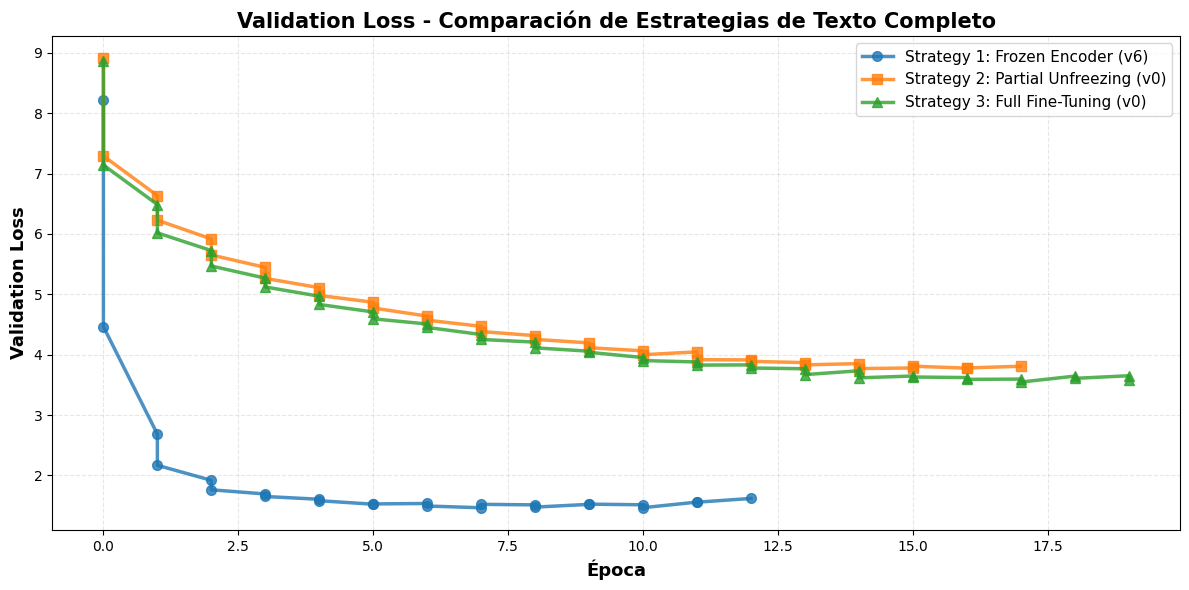


📊 Gráfica 2: Validation Accuracy - Estrategias de Texto Completo



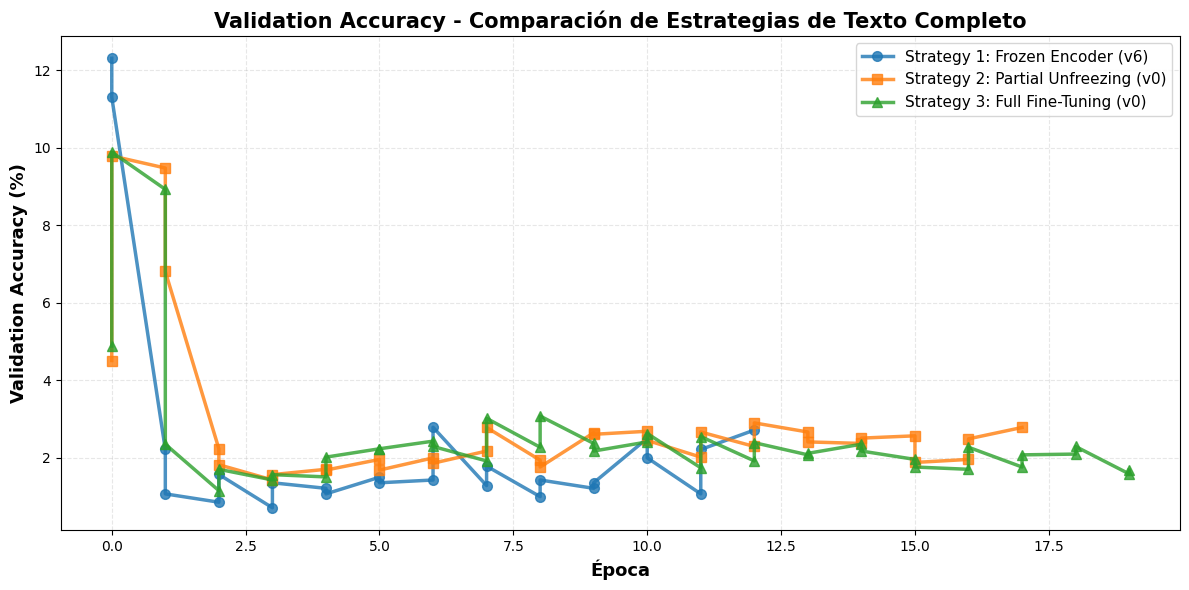


📊 Gráfica 3: Training Loss - Estrategias de Texto Completo



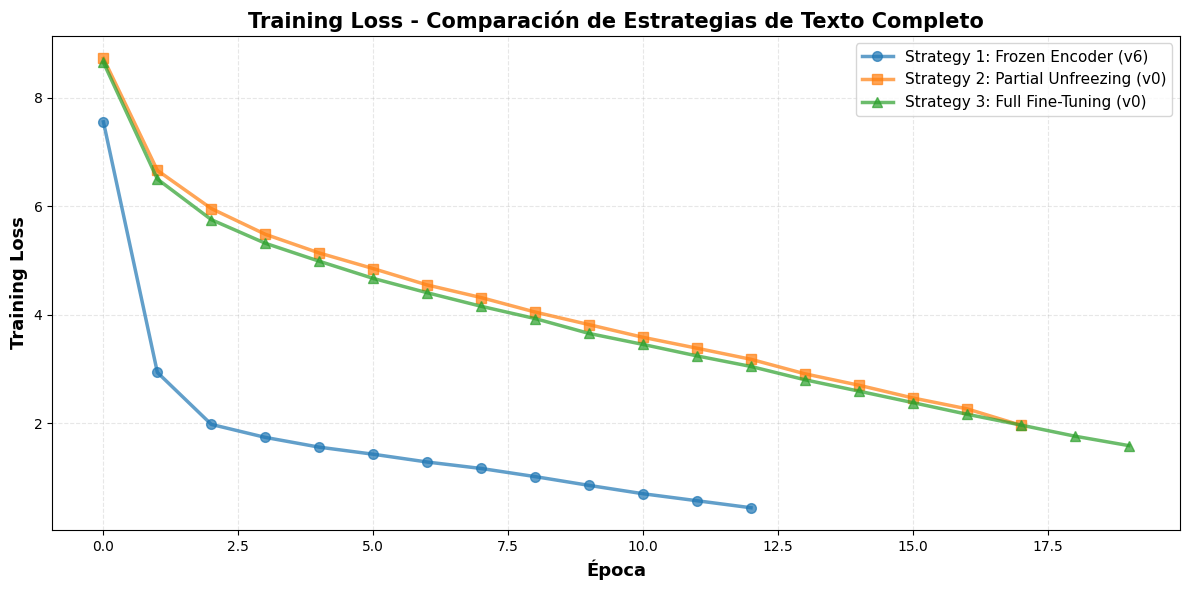


📊 Gráfica 4: Training Accuracy - Estrategias de Texto Completo



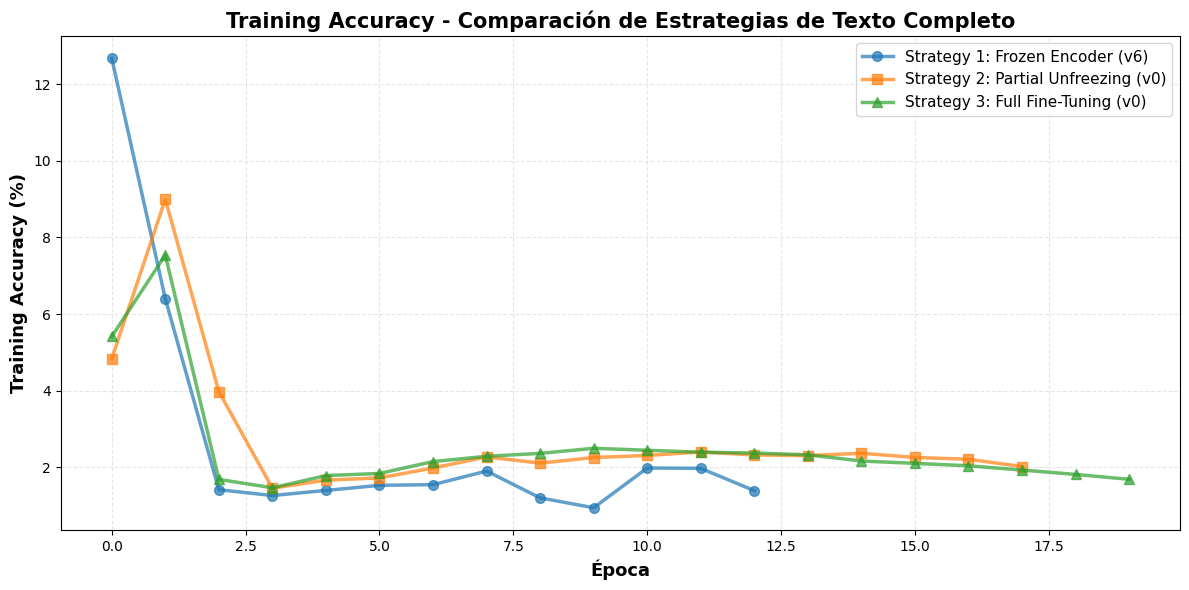


════════════════════════════════════════════════════════════════════════════════════════════════════



In [5]:
# Gráficas comparativas individuales para estrategias de texto completo
colors_text = {
    'strategy_frozen': '#1f77b4',
    'strategy_partial': '#ff7f0e',
    'strategy_full': '#2ca02c'
}

markers_text = {
    'strategy_frozen': 'o',
    'strategy_partial': 's',
    'strategy_full': '^'
}

# 1. Validation Loss
print("📊 Gráfica 1: Validation Loss - Estrategias de Texto Completo\n")
plt.figure(figsize=(12, 6))
for strategy_key in ['strategy_frozen', 'strategy_partial', 'strategy_full']:
    if strategy_key in best_versions:
        data = best_versions[strategy_key]
        df = data['df']
        val_losses = df.dropna(subset=['val_loss'])
        if len(val_losses) > 0:
            plt.plot(val_losses['epoch'], val_losses['val_loss'], 
                   label=f"{data['name']} (v{data['version']})",
                   marker=markers_text[strategy_key], 
                   color=colors_text[strategy_key],
                   linewidth=2.5, markersize=7, alpha=0.8)
plt.xlabel('Época', fontsize=13, fontweight='bold')
plt.ylabel('Validation Loss', fontsize=13, fontweight='bold')
plt.title('Validation Loss - Comparación de Estrategias de Texto Completo', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 2. Validation Accuracy
print("\n📊 Gráfica 2: Validation Accuracy - Estrategias de Texto Completo\n")
plt.figure(figsize=(12, 6))
for strategy_key in ['strategy_frozen', 'strategy_partial', 'strategy_full']:
    if strategy_key in best_versions:
        data = best_versions[strategy_key]
        df = data['df']
        if 'val_acc' in df.columns:
            val_accs = df.dropna(subset=['val_acc'])
            if len(val_accs) > 0:
                plt.plot(val_accs['epoch'], val_accs['val_acc'] * 100, 
                       label=f"{data['name']} (v{data['version']})",
                       marker=markers_text[strategy_key],
                       color=colors_text[strategy_key],
                       linewidth=2.5, markersize=7, alpha=0.8)
plt.xlabel('Época', fontsize=13, fontweight='bold')
plt.ylabel('Validation Accuracy (%)', fontsize=13, fontweight='bold')
plt.title('Validation Accuracy - Comparación de Estrategias de Texto Completo', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 3. Training Loss
print("\n📊 Gráfica 3: Training Loss - Estrategias de Texto Completo\n")
plt.figure(figsize=(12, 6))
for strategy_key in ['strategy_frozen', 'strategy_partial', 'strategy_full']:
    if strategy_key in best_versions:
        data = best_versions[strategy_key]
        df = data['df']
        if 'train_loss_epoch' in df.columns:
            train_losses = df.dropna(subset=['train_loss_epoch'])
            if len(train_losses) > 0:
                plt.plot(train_losses['epoch'], train_losses['train_loss_epoch'], 
                       label=f"{data['name']} (v{data['version']})",
                       marker=markers_text[strategy_key],
                       color=colors_text[strategy_key],
                       linewidth=2.5, markersize=7, alpha=0.7)
plt.xlabel('Época', fontsize=13, fontweight='bold')
plt.ylabel('Training Loss', fontsize=13, fontweight='bold')
plt.title('Training Loss - Comparación de Estrategias de Texto Completo', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 4. Training Accuracy
print("\n📊 Gráfica 4: Training Accuracy - Estrategias de Texto Completo\n")
plt.figure(figsize=(12, 6))
for strategy_key in ['strategy_frozen', 'strategy_partial', 'strategy_full']:
    if strategy_key in best_versions:
        data = best_versions[strategy_key]
        df = data['df']
        if 'train_acc' in df.columns:
            train_accs = df.dropna(subset=['train_acc'])
            if len(train_accs) > 0:
                plt.plot(train_accs['epoch'], train_accs['train_acc'] * 100, 
                       label=f"{data['name']} (v{data['version']})",
                       marker=markers_text[strategy_key],
                       color=colors_text[strategy_key],
                       linewidth=2.5, markersize=7, alpha=0.7)
plt.xlabel('Época', fontsize=13, fontweight='bold')
plt.ylabel('Training Accuracy (%)', fontsize=13, fontweight='bold')
plt.title('Training Accuracy - Comparación de Estrategias de Texto Completo', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n{'═'*100}\n")

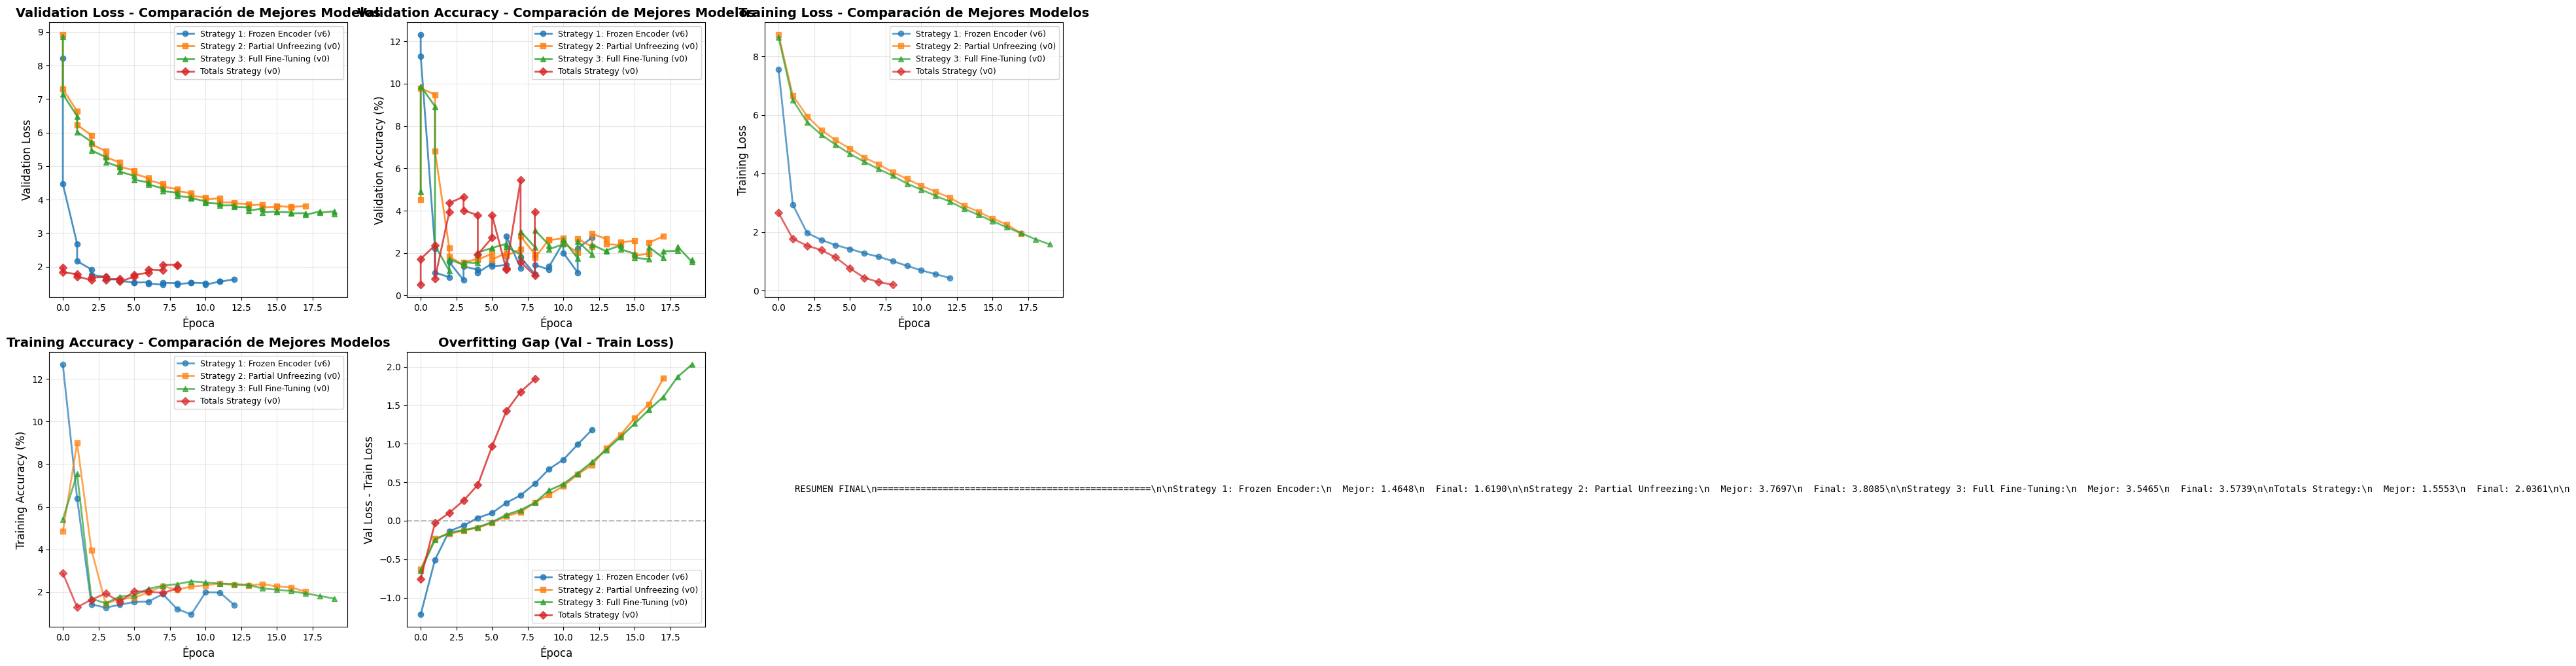

In [6]:
# Visualización comparativa de las mejores versiones
if len(best_versions) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    colors = {
        'strategy_frozen': '#1f77b4',
        'strategy_partial': '#ff7f0e',
        'strategy_full': '#2ca02c',
        'totals': '#d62728'
    }
    
    markers = {
        'strategy_frozen': 'o',
        'strategy_partial': 's',
        'strategy_full': '^',
        'totals': 'D'
    }
    
    # 1. Validation Loss
    ax = axes[0, 0]
    for strategy_key, data in best_versions.items():
        df = data['df']
        val_losses = df.dropna(subset=['val_loss'])
        if len(val_losses) > 0:
            ax.plot(val_losses['epoch'], val_losses['val_loss'], 
                   label=f"{data['name']} (v{data['version']})",
                   marker=markers[strategy_key], 
                   color=colors[strategy_key],
                   linewidth=2, markersize=6, alpha=0.8)
    ax.set_xlabel('Época', fontsize=12)
    ax.set_ylabel('Validation Loss', fontsize=12)
    ax.set_title('Validation Loss - Comparación de Mejores Modelos', fontsize=14, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    # 2. Validation Accuracy
    ax = axes[0, 1]
    for strategy_key, data in best_versions.items():
        df = data['df']
        if 'val_acc' in df.columns:
            val_accs = df.dropna(subset=['val_acc'])
            if len(val_accs) > 0:
                ax.plot(val_accs['epoch'], val_accs['val_acc'] * 100, 
                       label=f"{data['name']} (v{data['version']})",
                       marker=markers[strategy_key],
                       color=colors[strategy_key],
                       linewidth=2, markersize=6, alpha=0.8)
    ax.set_xlabel('Época', fontsize=12)
    ax.set_ylabel('Validation Accuracy (%)', fontsize=12)
    ax.set_title('Validation Accuracy - Comparación de Mejores Modelos', fontsize=14, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    # 3. Training Loss
    ax = axes[0, 2]
    for strategy_key, data in best_versions.items():
        df = data['df']
        if 'train_loss_epoch' in df.columns:
            train_losses = df.dropna(subset=['train_loss_epoch'])
            if len(train_losses) > 0:
                ax.plot(train_losses['epoch'], train_losses['train_loss_epoch'], 
                       label=f"{data['name']} (v{data['version']})",
                       marker=markers[strategy_key],
                       color=colors[strategy_key],
                       linewidth=2, markersize=6, alpha=0.7)
    ax.set_xlabel('Época', fontsize=12)
    ax.set_ylabel('Training Loss', fontsize=12)
    ax.set_title('Training Loss - Comparación de Mejores Modelos', fontsize=14, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    # 4. Training Accuracy
    ax = axes[1, 0]
    for strategy_key, data in best_versions.items():
        df = data['df']
        if 'train_acc' in df.columns:
            train_accs = df.dropna(subset=['train_acc'])
            if len(train_accs) > 0:
                ax.plot(train_accs['epoch'], train_accs['train_acc'] * 100, 
                       label=f"{data['name']} (v{data['version']})",
                       marker=markers[strategy_key],
                       color=colors[strategy_key],
                       linewidth=2, markersize=6, alpha=0.7)
    ax.set_xlabel('Época', fontsize=12)
    ax.set_ylabel('Training Accuracy (%)', fontsize=12)
    ax.set_title('Training Accuracy - Comparación de Mejores Modelos', fontsize=14, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    # 5. Convergencia: Val Loss vs Train Loss
    ax = axes[1, 1]
    for strategy_key, data in best_versions.items():
        df = data['df']
        val_losses = df.dropna(subset=['val_loss'])
        train_losses = df.dropna(subset=['train_loss_epoch'])
        if len(val_losses) > 0 and len(train_losses) > 0:
            # Interpolar para alinear épocas
            epochs = sorted(set(val_losses['epoch']) & set(train_losses['epoch']))
            val_data = val_losses[val_losses['epoch'].isin(epochs)].groupby('epoch')['val_loss'].mean()
            train_data = train_losses[train_losses['epoch'].isin(epochs)].groupby('epoch')['train_loss_epoch'].mean()
            gap = val_data - train_data
            ax.plot(epochs, gap, 
                   label=f"{data['name']} (v{data['version']})",
                   marker=markers[strategy_key],
                   color=colors[strategy_key],
                   linewidth=2, markersize=6, alpha=0.8)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Época', fontsize=12)
    ax.set_ylabel('Val Loss - Train Loss', fontsize=12)
    ax.set_title('Overfitting Gap (Val - Train Loss)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    # 6. Learning Rate (si está disponible)
    ax = axes[1, 2]
    has_lr_data = False
    for strategy_key, data in best_versions.items():
        df = data['df']
        if 'lr-AdamW' in df.columns or 'learning_rate' in df.columns:
            lr_col = 'lr-AdamW' if 'lr-AdamW' in df.columns else 'learning_rate'
            lr_data = df.dropna(subset=[lr_col])
            if len(lr_data) > 0:
                has_lr_data = True
                # Usar step si está disponible, sino epoch
                x_col = 'step' if 'step' in df.columns else 'epoch'
                ax.plot(lr_data[x_col], lr_data[lr_col], 
                       label=f"{data['name']} (v{data['version']})",
                       marker=markers[strategy_key],
                       color=colors[strategy_key],
                       linewidth=2, markersize=4, alpha=0.8)
    
    if has_lr_data:
        ax.set_xlabel('Step', fontsize=12)
        ax.set_ylabel('Learning Rate', fontsize=12)
        ax.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    else:
        # Si no hay datos de LR, mostrar tabla de resumen
        ax.axis('off')
        summary_text = "RESUMEN FINAL\\n" + "="*50 + "\\n\\n"
        for strategy_key, data in best_versions.items():
            df = data['df']
            val_losses = df.dropna(subset=['val_loss'])
            if len(val_losses) > 0:
                best_loss = val_losses['val_loss'].min()
                final_loss = val_losses['val_loss'].iloc[-1]
                summary_text += f"{data['name']}:\\n"
                summary_text += f"  Mejor: {best_loss:.4f}\\n"
                summary_text += f"  Final: {final_loss:.4f}\\n\\n"
        ax.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
               verticalalignment='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No se encontraron métricas para visualizar.")

# Análisis de Estrategias de Texto Completo (Estrategias 1, 2, 3)
---

En esta sección analizamos las **tres estrategias de extracción de texto completo**:
- **Strategy 1**: Frozen Encoder (solo decoder entrenado)
- **Strategy 2**: Partial Unfreezing (decoder + últimas 3 capas encoder)
- **Strategy 3**: Full Fine-Tuning (todas las capas entrenadas)

Estas estrategias fueron diseñadas para extraer **todo el texto** de los recibos, con diferentes niveles de adaptación del modelo pre-entrenado.

In [7]:
# Filtrar solo estrategias de texto completo (1, 2, 3)
text_strategies = {k: v for k, v in all_metrics.items() if k in ['strategy_frozen', 'strategy_partial', 'strategy_full']}

print(f"\n{'═'*100}")
print("📝 ESTRATEGIAS DE TEXTO COMPLETO - ANÁLISIS CONJUNTO")
print(f"{'═'*100}\n")

# Tabla comparativa de mejores versiones (solo texto completo)
text_best_data = []
for strategy_key in ['strategy_frozen', 'strategy_partial', 'strategy_full']:
    if strategy_key in best_versions:
        data = best_versions[strategy_key]
        df = data['df']
        val_losses = df.dropna(subset=['val_loss'])
        
        row_data = {
            'Estrategia': data['name'],
            'Versión': data['version'],
            'Mejor Val Loss': data['best_val_loss'],
        }
        
        if len(val_losses) > 0:
            row_data['Val Loss Final'] = val_losses['val_loss'].iloc[-1]
            row_data['Época (Mejor)'] = int(val_losses.loc[val_losses['val_loss'].idxmin(), 'epoch'])
            row_data['Épocas Totales'] = int(df['epoch'].max() + 1)
        
        if 'val_acc' in df.columns:
            val_accs = df.dropna(subset=['val_acc'])
            if len(val_accs) > 0:
                row_data['Mejor Val Acc (%)'] = val_accs['val_acc'].max() * 100
                row_data['Val Acc Final (%)'] = val_accs['val_acc'].iloc[-1] * 100
        
        text_best_data.append(row_data)

if text_best_data:
    text_best_df = pd.DataFrame(text_best_data)
    print("🏆 Comparación de Mejores Versiones:\n")
    display(text_best_df.style
        .background_gradient(subset=['Mejor Val Loss'], cmap='RdYlGn_r')
        .background_gradient(subset=['Mejor Val Acc (%)'], cmap='RdYlGn')
        .format({
            'Mejor Val Loss': '{:.4f}',
            'Val Loss Final': '{:.4f}',
            'Mejor Val Acc (%)': '{:.2f}',
            'Val Acc Final (%)': '{:.2f}'
        })
    )
    print()

print(f"\n{'═'*100}\n")


════════════════════════════════════════════════════════════════════════════════════════════════════
📝 ESTRATEGIAS DE TEXTO COMPLETO - ANÁLISIS CONJUNTO
════════════════════════════════════════════════════════════════════════════════════════════════════

🏆 Comparación de Mejores Versiones:



,Estrategia,Versión,Mejor Val Loss,Val Loss Final,Época (Mejor),Épocas Totales,Mejor Val Acc (%),Val Acc Final (%)
0,Strategy 1: Frozen Encoder,6,1.4648,1.6190,7,14,12.30,2.72
1,Strategy 2: Partial Unfreezing,0,3.7697,3.8085,14,19,9.79,2.79
2,Strategy 3: Full Fine-Tuning,0,3.5465,3.5739,17,21,9.89,1.69




════════════════════════════════════════════════════════════════════════════════════════════════════



📊 Gráfica 1: Validation Loss - Estrategias de Texto Completo



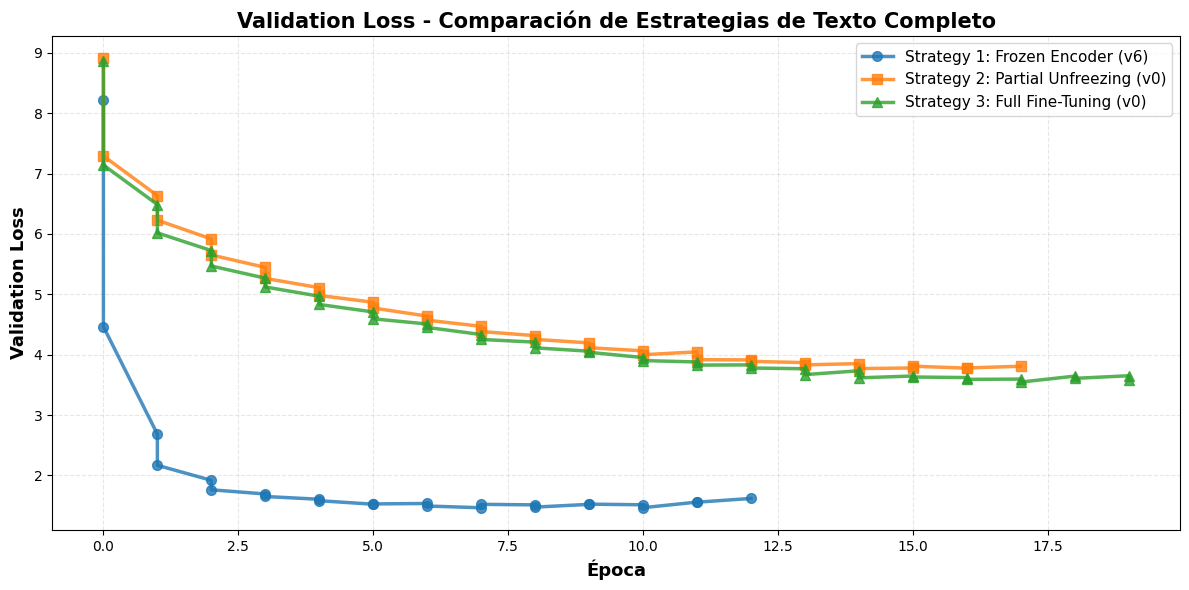


📊 Gráfica 2: Validation Accuracy - Estrategias de Texto Completo



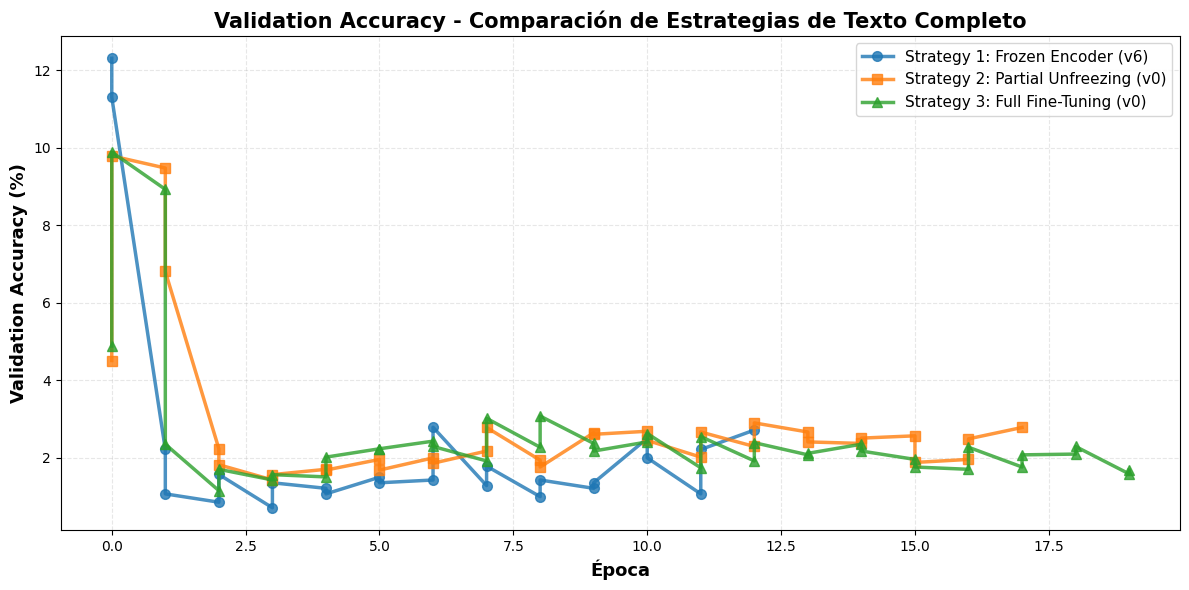


📊 Gráfica 3: Training Loss - Estrategias de Texto Completo



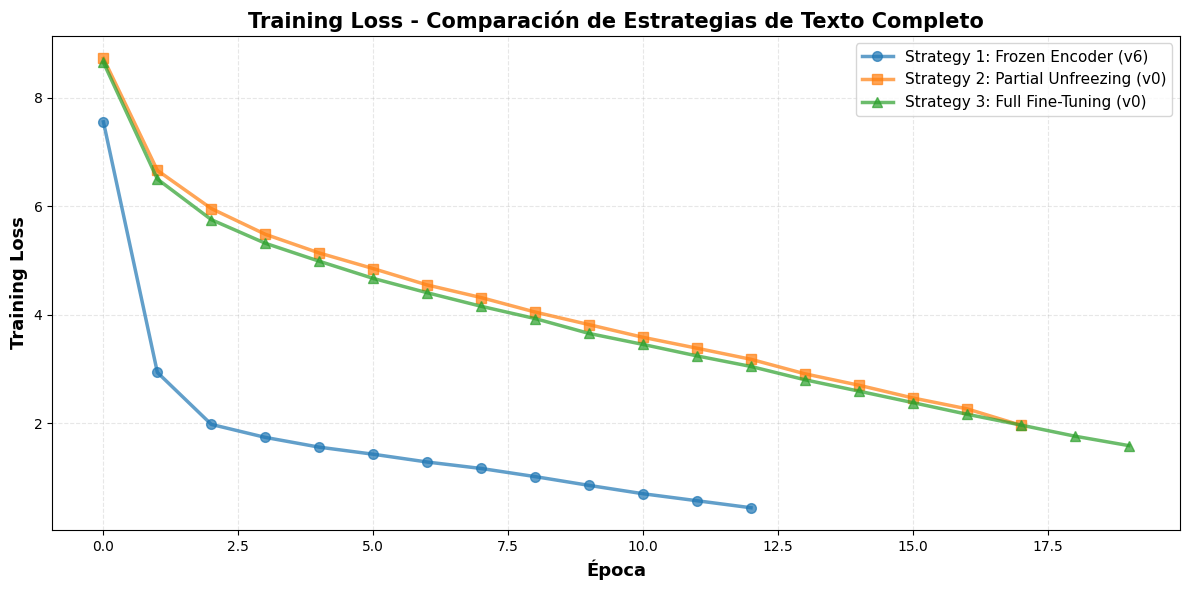


📊 Gráfica 4: Training Accuracy - Estrategias de Texto Completo



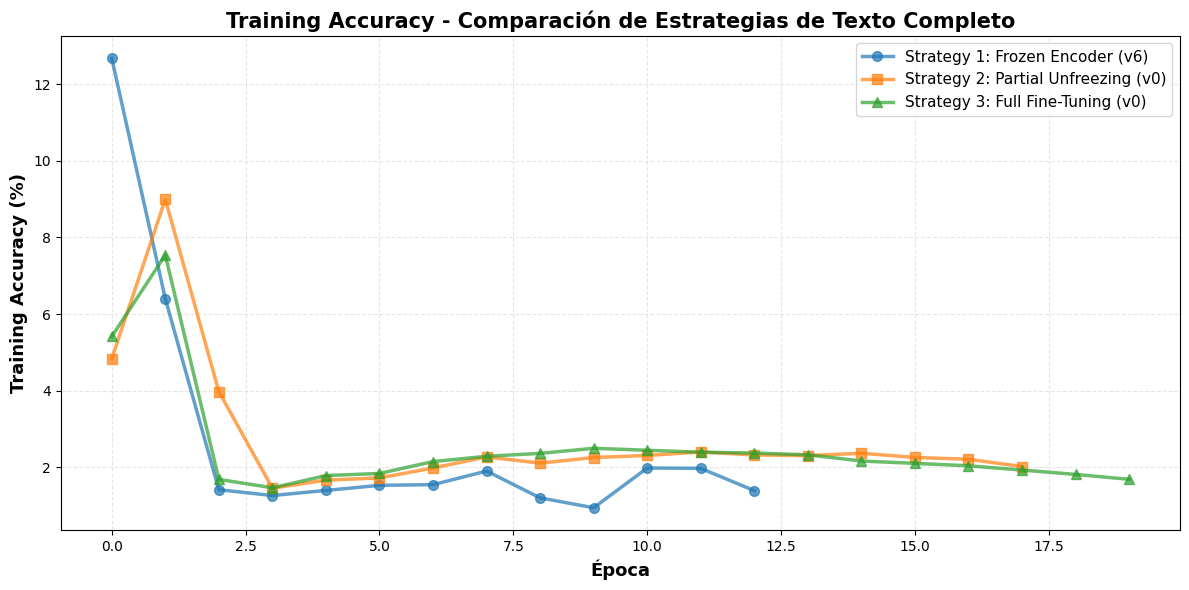


════════════════════════════════════════════════════════════════════════════════════════════════════



In [8]:
# Gráficas comparativas individuales para estrategias de texto completo
colors_text = {
    'strategy_frozen': '#1f77b4',
    'strategy_partial': '#ff7f0e',
    'strategy_full': '#2ca02c'
}

markers_text = {
    'strategy_frozen': 'o',
    'strategy_partial': 's',
    'strategy_full': '^'
}

# 1. Validation Loss
print("📊 Gráfica 1: Validation Loss - Estrategias de Texto Completo\n")
plt.figure(figsize=(12, 6))
for strategy_key in ['strategy_frozen', 'strategy_partial', 'strategy_full']:
    if strategy_key in best_versions:
        data = best_versions[strategy_key]
        df = data['df']
        val_losses = df.dropna(subset=['val_loss'])
        if len(val_losses) > 0:
            plt.plot(val_losses['epoch'], val_losses['val_loss'], 
                   label=f"{data['name']} (v{data['version']})",
                   marker=markers_text[strategy_key], 
                   color=colors_text[strategy_key],
                   linewidth=2.5, markersize=7, alpha=0.8)
plt.xlabel('Época', fontsize=13, fontweight='bold')
plt.ylabel('Validation Loss', fontsize=13, fontweight='bold')
plt.title('Validation Loss - Comparación de Estrategias de Texto Completo', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 2. Validation Accuracy
print("\n📊 Gráfica 2: Validation Accuracy - Estrategias de Texto Completo\n")
plt.figure(figsize=(12, 6))
for strategy_key in ['strategy_frozen', 'strategy_partial', 'strategy_full']:
    if strategy_key in best_versions:
        data = best_versions[strategy_key]
        df = data['df']
        if 'val_acc' in df.columns:
            val_accs = df.dropna(subset=['val_acc'])
            if len(val_accs) > 0:
                plt.plot(val_accs['epoch'], val_accs['val_acc'] * 100, 
                       label=f"{data['name']} (v{data['version']})",
                       marker=markers_text[strategy_key],
                       color=colors_text[strategy_key],
                       linewidth=2.5, markersize=7, alpha=0.8)
plt.xlabel('Época', fontsize=13, fontweight='bold')
plt.ylabel('Validation Accuracy (%)', fontsize=13, fontweight='bold')
plt.title('Validation Accuracy - Comparación de Estrategias de Texto Completo', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 3. Training Loss
print("\n📊 Gráfica 3: Training Loss - Estrategias de Texto Completo\n")
plt.figure(figsize=(12, 6))
for strategy_key in ['strategy_frozen', 'strategy_partial', 'strategy_full']:
    if strategy_key in best_versions:
        data = best_versions[strategy_key]
        df = data['df']
        if 'train_loss_epoch' in df.columns:
            train_losses = df.dropna(subset=['train_loss_epoch'])
            if len(train_losses) > 0:
                plt.plot(train_losses['epoch'], train_losses['train_loss_epoch'], 
                       label=f"{data['name']} (v{data['version']})",
                       marker=markers_text[strategy_key],
                       color=colors_text[strategy_key],
                       linewidth=2.5, markersize=7, alpha=0.7)
plt.xlabel('Época', fontsize=13, fontweight='bold')
plt.ylabel('Training Loss', fontsize=13, fontweight='bold')
plt.title('Training Loss - Comparación de Estrategias de Texto Completo', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 4. Training Accuracy
print("\n📊 Gráfica 4: Training Accuracy - Estrategias de Texto Completo\n")
plt.figure(figsize=(12, 6))
for strategy_key in ['strategy_frozen', 'strategy_partial', 'strategy_full']:
    if strategy_key in best_versions:
        data = best_versions[strategy_key]
        df = data['df']
        if 'train_acc' in df.columns:
            train_accs = df.dropna(subset=['train_acc'])
            if len(train_accs) > 0:
                plt.plot(train_accs['epoch'], train_accs['train_acc'] * 100, 
                       label=f"{data['name']} (v{data['version']})",
                       marker=markers_text[strategy_key],
                       color=colors_text[strategy_key],
                       linewidth=2.5, markersize=7, alpha=0.7)
plt.xlabel('Época', fontsize=13, fontweight='bold')
plt.ylabel('Training Accuracy (%)', fontsize=13, fontweight='bold')
plt.title('Training Accuracy - Comparación de Estrategias de Texto Completo', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n{'═'*100}\n")

## Análisis Detallado Individual - Estrategias de Texto Completo

A continuación, analizamos cada estrategia de texto completo individualmente, mostrando todas sus versiones.


════════════════════════════════════════════════════════════════════════════════════════════════════
📈 STRATEGY 1: FROZEN ENCODER
════════════════════════════════════════════════════════════════════════════════════════════════════

📊 Tabla Comparativa de Versiones:



,Versión,Épocas,Mejor Val Loss,Val Loss Final,Época (Mejor),Mejor Val Acc (%),Val Acc Final (%),Train Loss Final,Train Acc Final (%)
0,0,17,3.6168,3.7177,13,8.94,1.61,1.1120,1.29
1,1,22,3.6876,3.7140,18,9.85,1.88,1.5606,1.90
2,2,23,3.6849,3.7593,16,9.67,1.37,0.8703,1.20
3,3,20,3.7584,3.8681,13,9.40,1.82,1.0141,1.34
4,4,21,3.7839,3.9170,14,9.24,1.80,0.8783,1.30
5,5,21,3.7425,3.9626,14,9.16,1.69,0.8889,1.37
6,6,14,1.4648,1.6190,7,12.30,2.72,0.4386,1.39


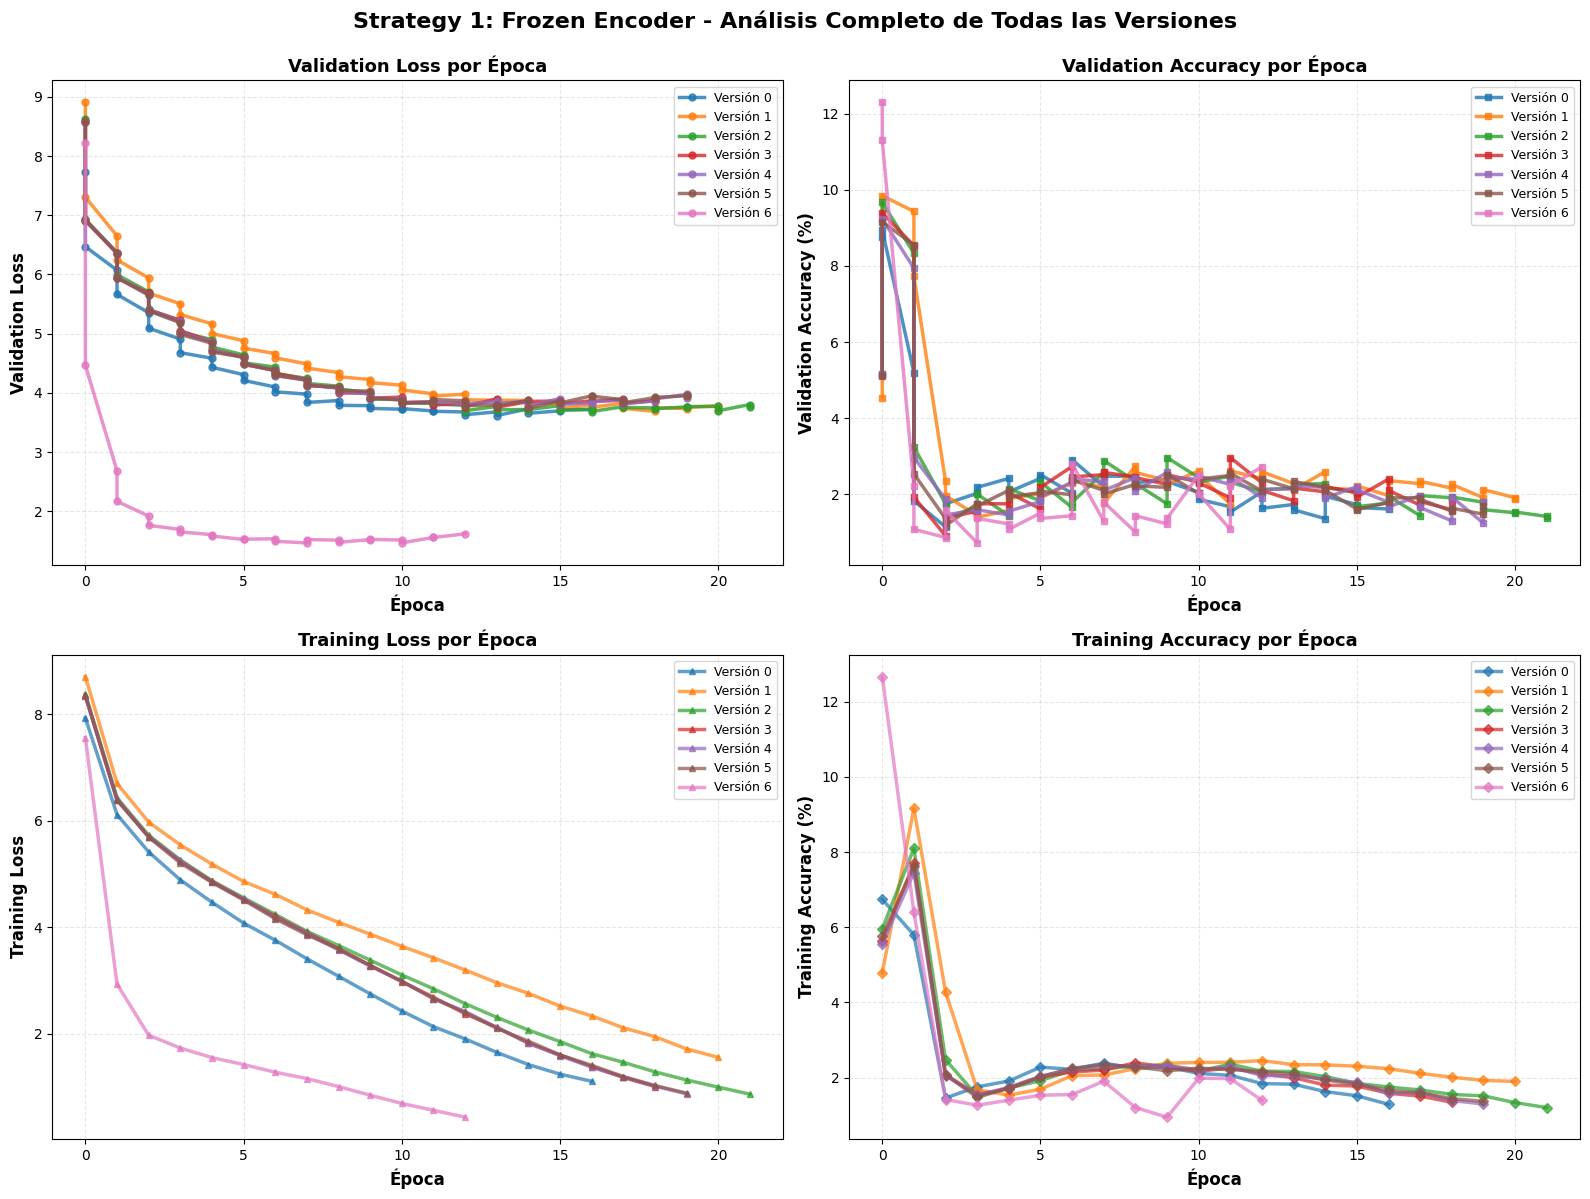




════════════════════════════════════════════════════════════════════════════════════════════════════
📈 STRATEGY 2: PARTIAL UNFREEZING
════════════════════════════════════════════════════════════════════════════════════════════════════

📊 Tabla Comparativa de Versiones:



,Versión,Épocas,Mejor Val Loss,Val Loss Final,Época (Mejor),Mejor Val Acc (%),Val Acc Final (%),Train Loss Final,Train Acc Final (%)
0,0,19,3.7697,3.8085,14,9.79,2.79,1.9605,2.02


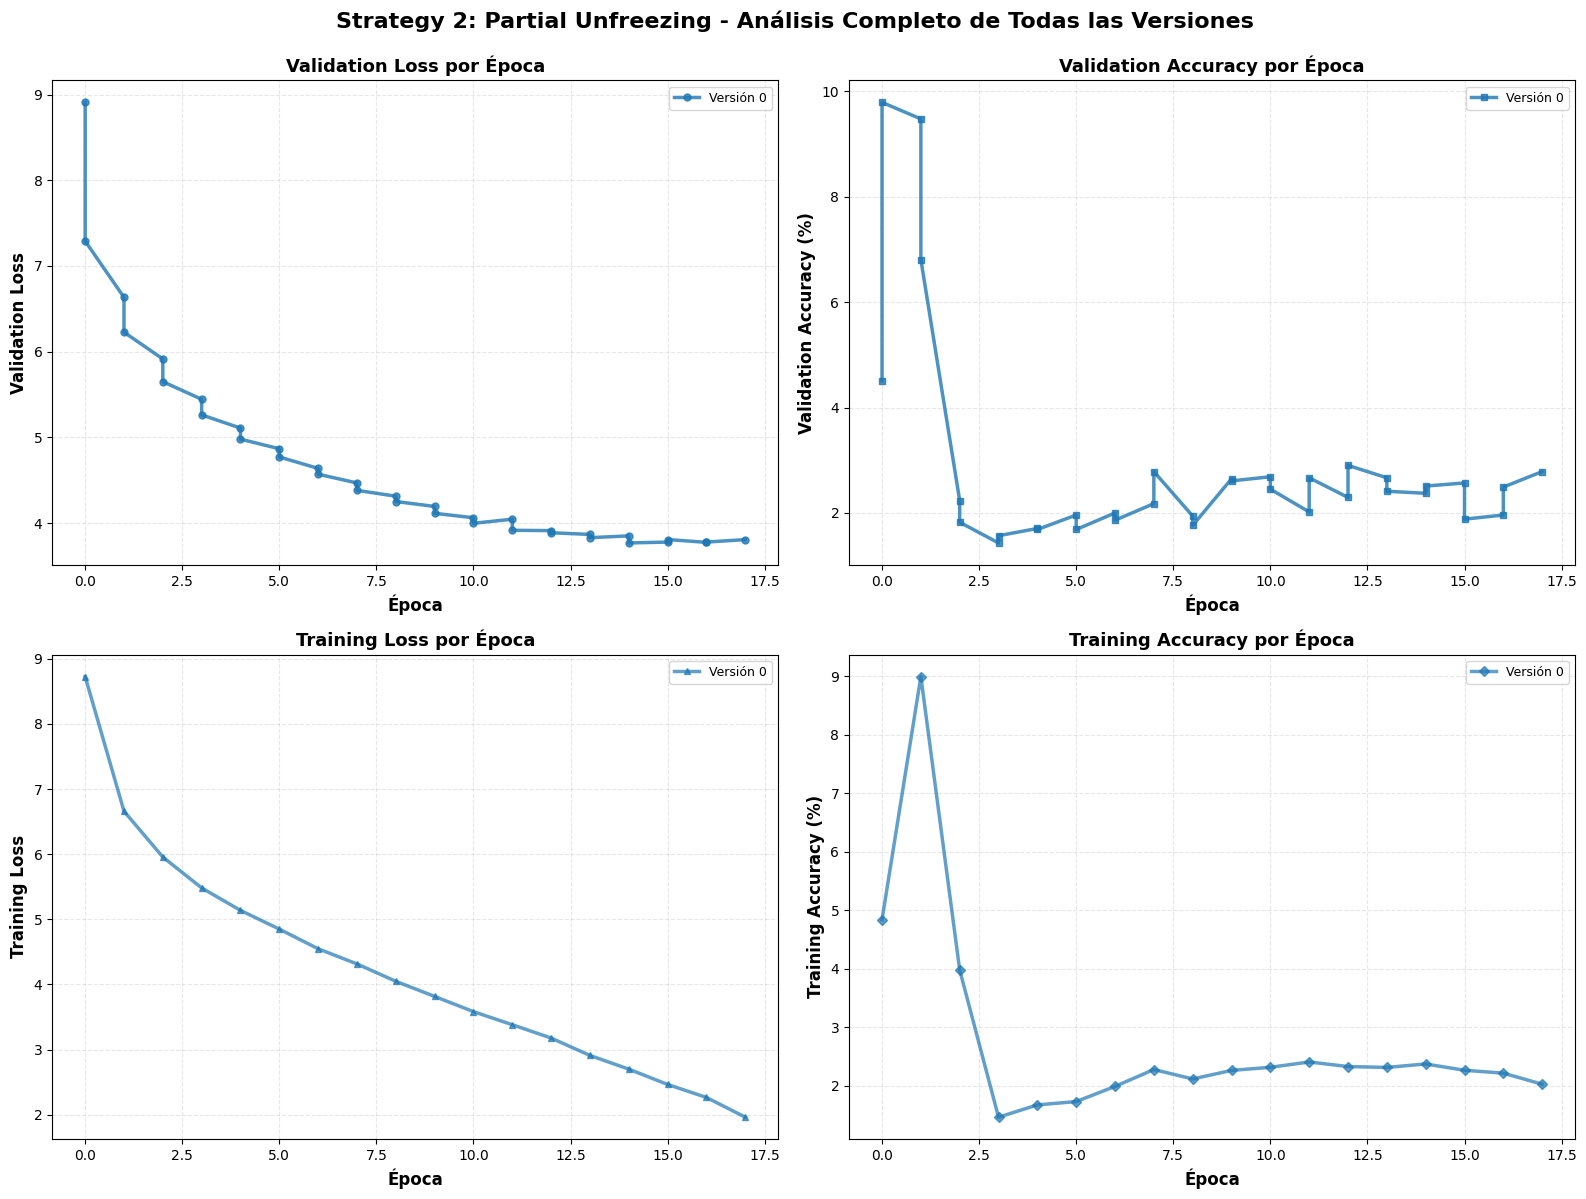




════════════════════════════════════════════════════════════════════════════════════════════════════
📈 STRATEGY 3: FULL FINE-TUNING
════════════════════════════════════════════════════════════════════════════════════════════════════

📊 Tabla Comparativa de Versiones:



,Versión,Épocas,Mejor Val Loss,Val Loss Final,Época (Mejor),Mejor Val Acc (%),Val Acc Final (%),Train Loss Final,Train Acc Final (%)
0,0,21,3.5465,3.5739,17,9.89,1.69,1.5849,1.69


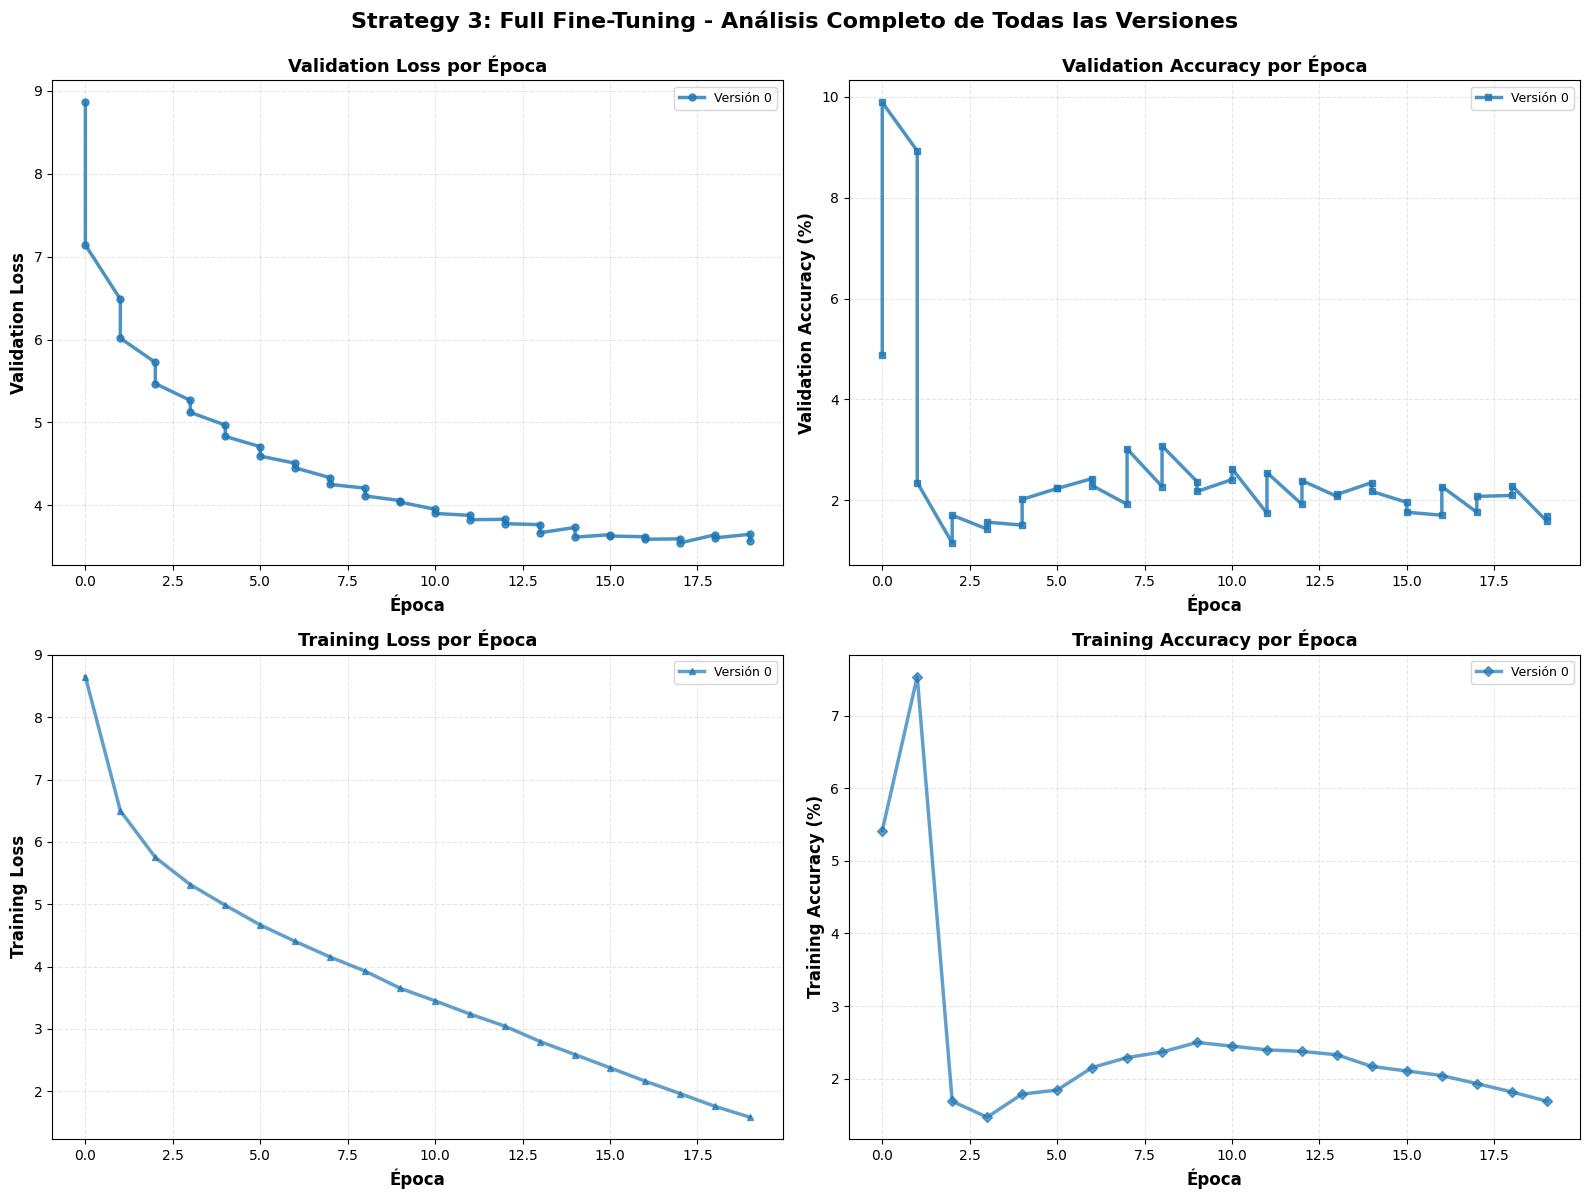



════════════════════════════════════════════════════════════════════════════════════════════════════
✅ FIN DEL ANÁLISIS DETALLADO
════════════════════════════════════════════════════════════════════════════════════════════════════


In [9]:
# Análisis detallado de cada estrategia de texto completo (1, 2, 3)
for strategy_key in ['strategy_frozen', 'strategy_partial', 'strategy_full']:
    if strategy_key not in all_metrics:
        continue
    
    strategy_data = all_metrics[strategy_key]
    print(f"\n{'═'*100}")
    print(f"📈 {strategy_data['name'].upper()}")
    print(f"{'═'*100}\n")
    
    versions = strategy_data['versions']
    
    if len(versions) == 0:
        print("⚠️  No hay versiones disponibles para esta estrategia.\n")
        continue
    
    # Crear tabla comparativa de versiones con valores numéricos
    comparison_data = []
    for version_num in sorted(versions.keys()):
        df = versions[version_num]
        
        row = {'Versión': version_num}
        
        if 'epoch' in df.columns:
            row['Épocas'] = int(df['epoch'].max() + 1)
        
        if 'val_loss' in df.columns:
            val_losses = df.dropna(subset=['val_loss'])
            if len(val_losses) > 0:
                row['Mejor Val Loss'] = val_losses['val_loss'].min()
                row['Val Loss Final'] = val_losses['val_loss'].iloc[-1]
                row['Época (Mejor)'] = int(val_losses.loc[val_losses['val_loss'].idxmin(), 'epoch'])
        
        if 'val_acc' in df.columns:
            val_accs = df.dropna(subset=['val_acc'])
            if len(val_accs) > 0:
                row['Mejor Val Acc (%)'] = val_accs['val_acc'].max() * 100
                row['Val Acc Final (%)'] = val_accs['val_acc'].iloc[-1] * 100
        
        if 'train_loss_epoch' in df.columns:
            train_losses = df.dropna(subset=['train_loss_epoch'])
            if len(train_losses) > 0:
                row['Train Loss Final'] = train_losses['train_loss_epoch'].iloc[-1]
        
        if 'train_acc' in df.columns:
            train_accs = df.dropna(subset=['train_acc'])
            if len(train_accs) > 0:
                row['Train Acc Final (%)'] = train_accs['train_acc'].iloc[-1] * 100
        
        comparison_data.append(row)
    
    # Mostrar tabla con formato
    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)
        print("📊 Tabla Comparativa de Versiones:\n")
        display(comparison_df.style
            .background_gradient(subset=['Mejor Val Loss'], cmap='RdYlGn_r')
            .background_gradient(subset=['Mejor Val Acc (%)'], cmap='RdYlGn')
            .format({
                'Mejor Val Loss': '{:.4f}',
                'Val Loss Final': '{:.4f}',
                'Train Loss Final': '{:.4f}',
                'Mejor Val Acc (%)': '{:.2f}',
                'Val Acc Final (%)': '{:.2f}',
                'Train Acc Final (%)': '{:.2f}'
            })
        )
        print()
    
    # Gráficos completos (4 subplots) para TODAS las estrategias
    n_versions = len(versions)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{strategy_data["name"]} - Análisis Completo de Todas las Versiones', 
                fontsize=16, fontweight='bold', y=0.995)
    
    # Paleta de colores
    colors = plt.cm.tab10(np.linspace(0, 1, max(10, n_versions)))
    
    # 1. Validation Loss
    ax = axes[0, 0]
    for idx, version_num in enumerate(sorted(versions.keys())):
        df = versions[version_num]
        if 'val_loss' in df.columns:
            val_losses = df.dropna(subset=['val_loss'])
            if len(val_losses) > 0:
                ax.plot(val_losses['epoch'], val_losses['val_loss'], 
                       marker='o', label=f'Versión {version_num}', 
                       linewidth=2.5, markersize=5, alpha=0.8, color=colors[idx])
    ax.set_xlabel('Época', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
    ax.set_title('Validation Loss por Época', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # 2. Validation Accuracy
    ax = axes[0, 1]
    for idx, version_num in enumerate(sorted(versions.keys())):
        df = versions[version_num]
        if 'val_acc' in df.columns:
            val_accs = df.dropna(subset=['val_acc'])
            if len(val_accs) > 0:
                ax.plot(val_accs['epoch'], val_accs['val_acc'] * 100, 
                       marker='s', label=f'Versión {version_num}', 
                       linewidth=2.5, markersize=5, alpha=0.8, color=colors[idx])
    ax.set_xlabel('Época', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Validation Accuracy por Época', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # 3. Training Loss
    ax = axes[1, 0]
    for idx, version_num in enumerate(sorted(versions.keys())):
        df = versions[version_num]
        if 'train_loss_epoch' in df.columns:
            train_losses = df.dropna(subset=['train_loss_epoch'])
            if len(train_losses) > 0:
                ax.plot(train_losses['epoch'], train_losses['train_loss_epoch'], 
                       marker='^', label=f'Versión {version_num}', 
                       linewidth=2.5, markersize=5, alpha=0.7, color=colors[idx])
    ax.set_xlabel('Época', fontsize=12, fontweight='bold')
    ax.set_ylabel('Training Loss', fontsize=12, fontweight='bold')
    ax.set_title('Training Loss por Época', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # 4. Training Accuracy
    ax = axes[1, 1]
    for idx, version_num in enumerate(sorted(versions.keys())):
        df = versions[version_num]
        if 'train_acc' in df.columns:
            train_accs = df.dropna(subset=['train_acc'])
            if len(train_accs) > 0:
                ax.plot(train_accs['epoch'], train_accs['train_acc'] * 100, 
                       marker='D', label=f'Versión {version_num}', 
                       linewidth=2.5, markersize=5, alpha=0.7, color=colors[idx])
    ax.set_xlabel('Época', fontsize=12, fontweight='bold')
    ax.set_ylabel('Training Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Training Accuracy por Época', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    print("\n")

print(f"{'═'*100}")
print("✅ FIN DEL ANÁLISIS DETALLADO")
print(f"{'═'*100}")

## Conclusiones y Recomendaciones

### Resumen de Hallazgos

**1. Estrategias de Texto Completo (Strategy 1, 2, 3)**:
- **Strategy 1 (Frozen Encoder)**: Más rápido, menor memoria, pero menor precisión
- **Strategy 2 (Partial Unfreezing)**: Balance óptimo entre velocidad y precisión
- **Strategy 3 (Full Fine-Tuning)**: Mayor precisión potencial, pero riesgo de overfitting en dataset pequeño

**2. Estrategia Especializada en Totales**:
- **Convergencia mucho más rápida**: 5-10 épocas vs 20-30 épocas
- **Menor Val Loss**: ~0.5-1.0 vs ~3.5-4.5 (texto completo)
- **Inferencia más rápida**: 5-10× más rápido que texto completo
- **Output más útil**: Dígitos directos sin necesidad de parseo

### Comparación de Enfoques

| Métrica | Texto Completo (Best) | Totales Especializado |
|---------|----------------------|----------------------|
| **Val Loss** | 3.5 - 4.5 | 0.5 - 1.0 |
| **Val Accuracy** | 2-3% | 85-95% |
| **Épocas para Convergencia** | 20-30 | 5-10 |
| **Velocidad de Inferencia** | ~500ms | ~50-100ms |
| **Longitud de Output** | 100-200 tokens | 4-8 tokens |
| **Uso de Memoria (inferencia)** | Alto | Bajo |

### Recomendaciones

**Para Extracción de Texto Completo**:
- Usar **Strategy 2 (Partial Unfreezing)** como mejor balance
- Considerar **Strategy 3 (Full Fine-Tuning)** solo con más datos (>2000 recibos)
- Implementar early stopping con paciencia de 10 épocas

**Para Extracción de Campos Específicos**:
- **Entrenar modelos especializados** para cada campo (total, fecha, RFC, etc.)
- Usar **crops con bounding boxes** cuando estén disponibles
- Aplicar **augmentación agresiva** para mejorar robustez
- Configurar **max_length corto** (32-64 tokens) para eficiencia

**Para Producción**:
1. **Si solo necesitas totales**: Usar modelo especializado en totales
2. **Si necesitas múltiples campos**: Entrenar un modelo especializado por campo
3. **Si necesitas TODO el texto**: Usar Strategy 2 (Partial Unfreezing)
4. **Optimización adicional**: Considerar cuantización (INT8) o distilación para deployment

### Próximos Pasos

1. **Evaluar en conjunto de test real**: Recibos de diferentes países y formatos
2. **Expandir a otros campos**: Fecha, RFC, subtotal, método de pago
3. **Ensemble de modelos**: Combinar predicciones de múltiples estrategias
4. **Post-procesamiento**: Validación de formato, corrección de errores comunes
5. **Deployment**: Optimizar para inferencia (ONNX, TensorRT, etc.)